First of all, docker needed to be installed and elasticsearch 7.9.2 should be added as a container. This provides a similar configuration as the interface backend.

# Initial Setup

In [1]:
import os
import requests
import json

os.environ['USE_TORCH'] = 'YES'

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from haystack.document_stores import ElasticsearchDocumentStore
from haystack.nodes import FARMReader, BM25Retriever
from haystack.pipelines import ExtractiveQAPipeline

In [4]:
reader = FARMReader(model_name_or_path="IVN-RIN/medBIT-r3-plus", use_gpu=False)
document_store = ElasticsearchDocumentStore()
retriever = BM25Retriever(document_store=document_store)
pipe = ExtractiveQAPipeline(reader, retriever)

d:\Thesis\Evaluation\PatientSearch\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at IVN-RIN/medBIT-r3-plus and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def add_documents(documents):
    document_store.write_documents(documents)

directory_path = "D:/AA_THESIS/Asclepius-Synthetic-Clinical-Notes/Dataset" # Change this to the path of the directory containing the documents

documents = []
for filename in os.listdir(directory_path):
    if filename.endswith(".txt"):
        with open(os.path.join(directory_path, filename), 'r', encoding='utf-8') as file:
            content = file.read()
            documents.append({"content": content, "meta": {"name": filename}})


In [6]:
add_documents(documents)

# Functions

In [7]:
outputs_list = []
def search(query):
    prediction = pipe.run(
        query=query,
        params={
            "Retriever": {"top_k": 10},
            "Reader": {"top_k": 10}
        }
    )
    
    outputs = []
    for document in prediction['documents']:
        output_dict = {}
        output_dict['text'] = document.content
        output_dict['document_score'] = document.score
        output_dict['document_id'] = document.id[0:5]
        for answer in prediction['answers']:
            if (answer.document_ids[0] == document.id):
                output_dict['context'] = answer.context
                output_dict['answer'] = answer.answer
        outputs.append(output_dict)

    # Store the results in the cache
    outputs_list.append(outputs)
    return  outputs

In [ ]:
def ask_to_llm(prompt, system_message="You are a helpful assistant and a medical expert"): # changes in the system message is the first step of prompting the model
    data = {
        "messages": [
            {
                "content": system_message,
                "role": "system"
            },
            {
                "content": prompt,
                "role": "user"
            }
        ],
        'temperature': 0,
        'max_tokens': 500,
        # 'mirostat_tau': 0.0
    }
    headers = {
        "accept": "application/json",
        "Content-Type": "application/json",
    }
    response = requests.post(
        "http://131.175.15.22:61111/llama-server/v1/chat/completions/",
        headers=headers,
        json=data
    )

    if response.ok:
        completion_json = json.loads(response.text)
        completion_text = completion_json['choices'][0]['message']['content']
        return completion_text
    else:
        raise ValueError(f"Request problem. Status Code: {response.status_code}")
    

# Old Prompt

In [58]:
def criteria_check(criteria):
    patient_search_output = outputs_list[-1] if outputs_list else []
    i_criteria = []
    for document in patient_search_output:
        prompt = f'''Given the following clinical text:
        ```
        {document['text']}
        ```
        and given the following eligibility inclusion criteria for a clinical trial:
        ```
        {criteria}
        ```
        Determine whether the patient would be elegible for the clinical trial, responding either "Elegible, because:" or "Not elegible, because:"  
        '''
        
        answer = ask_to_llm(prompt)
        i_criteria.append(answer)

    return i_criteria

## Diabetes

In [59]:
query = "diabetes type 2"
prediction = search(query)

Inferencing Samples: 100%|██████████| 1/1 [00:11<00:00, 11.20s/ Batches]


In [42]:
for i, item in enumerate(prediction):
    print(f"Document {i+1}:")
    print(item['text'])

Document 1:
Patient Information:
A 50-year-old woman with a history of type 2 diabetes, high blood pressure, high cholesterol, and hypothyroidism.

Hospital Course:
The patient was referred to the Department of Endocrinology and Metabolism at the First Hospital of China Medical University for evaluation. The patient had a history of type 2 diabetes and hypothyroidism, both of which were being treated at the endocrine clinic. During the evaluation, the patient and her family members were noted to have mesomelia and Madelung deformity. A genetic test revealed a heterozygous missense mutation in SHOX-coding exons. The patient was started on a treatment plan consisting of diet control, exercise, and various medications to manage her type 2 diabetes, high blood pressure, high cholesterol, and hypothyroidism. 

Summary:
The patient, a 50-year-old woman with a history of type 2 diabetes, high blood pressure, high cholesterol, and hypothyroidism, was evaluated for mesomelia and Madelung deform

In [60]:
criteria = "age 40 to 60"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Elegible, because: The patient's age is within the range of 40-60 years old, which meets one of the eligibility inclusion criteria.",
 2: "Not eligible, because: The patient's age is 67 years, which falls outside the eligibility criteria of 40 to 60 years.",
 3: "Not eligible, because: The patient's age is 23 years, which falls outside the eligibility criteria of 40 to 60 years.",
 4: "Not eligible, because: The patient's age is 69 years old, which falls outside the eligibility criteria of 40 to 60 years old.",
 5: 'Elegible, because: The patient is 51 years old, which falls within the age range of 40 to 60 specified in the eligibility inclusion criteria.',
 6: "Eligible, because: The patient's age is within the specified range of 40 to 60 years old.",
 7: "Eligible, because: The patient's age is within the range of 40-60 years old, which meets one of the eligibility criteria.",
 8: "Not eligible, because: The patient's age is not within the specified range of 40 to 60 years old. 

### Second Trial

In [61]:
criteria = "Male, Type 2 Diabetes Mellitus, Age 60 to 70"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: 'Not eligible, because:\n\n* The patient is a female, whereas the eligibility criteria specify "Male".\n* The patient\'s age (50) falls outside the specified range of 60-70 years old.',
 2: 'Elegible, because: The patient is a male with Type 2 Diabetes Mellitus, and his age (67 years) falls within the specified range of 60 to 70 years.',
 3: "Not eligible, because:\n\n* The patient is a female (not male)\n* The patient has Type 2 Diabetes Mellitus, but it's not within the age range of 60-70 years old (the patient is only 23 years old)",
 4: 'Not eligible, because:\n\n* The patient is a 69-year-old female, whereas the eligibility criteria specify that participants must be male.\n* The patient has type 2 diabetes mellitus, which meets one of the inclusion criteria. However, the other criterion (age 60 to 70) is not met since the patient is 69 years old, just outside the specified age range.',
 5: 'Elegible, because:\n\nThe patient is a male with Type 2 Diabetes Mellitus, which matche

In [62]:
criteria = "Male, History of hypertension, Age 60 to 70"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Not eligible, because:\n\n* The patient is a female (not male)\n* The patient's age is 50 years old (outside the range of 60-70 years old)",
 2: "Elegible, because:\n\n* The patient is male, which matches one of the inclusion criteria.\n* The patient has a history of hypertension, which matches another inclusion criterion.\n* The patient's age (67 years) falls within the range specified in the inclusion criteria (60 to 70).",
 3: "Not eligible, because:\n\n* The patient is a female (not male)\n* The patient has a history of beta thalassaemia major and type 2 diabetes mellitus, but not hypertension\n* The patient's age is 23 years, which falls outside the eligibility criteria range of 60-70 years.",
 4: 'Not eligible, because:\n\n* The patient is a 69-year-old female, whereas the eligibility criteria specify "Male".\n* The patient has a history of type 2 diabetes and HBV infection, but not hypertension.',
 5: 'Not eligible, because:\n\n* The patient is 51 years old, which falls out

In [63]:
criteria = "old female, history of hypertension"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: 'Elegible, because:\n\nThe patient is an old female (50 years old) and has a history of hypertension. She meets both inclusion criteria for the clinical trial.',
 2: 'Not eligible, because:\n\nThe inclusion criteria specify "old female", but the patient is a 67-year-old male. Therefore, the patient does not meet the age criterion for eligibility.',
 3: 'Not eligible, because:\n\nThe inclusion criteria specify "old female", but the patient is only 23 years old. The patient also does not have a history of hypertension, which is another criterion for eligibility. Therefore, the patient does not meet the eligibility criteria for the clinical trial.',
 4: 'Not eligible, because:\n\nThe inclusion criteria specify "old female", which is met by the patient. However, there is no mention of hypertension in the patient\'s medical history, which is a required criterion for eligibility. Therefore, the patient would not be eligible for the clinical trial due to lack of hypertension diagnosis or 

### Third Trial (Without age specification)

In [64]:
criteria = "adults with a diagnosis of T2D, excluded patients with a diagnosis of type 1 diabetes, gestational diabetes mellitus, and any other type of diabetes"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: 'Elegible, because: The patient has a diagnosis of T2D (type 2 diabetes), which meets one of the inclusion criteria. However, it is important to note that the patient also has other underlying conditions such as high blood pressure, high cholesterol, and hypothyroidism, but these are not exclusion criteria for the clinical trial.',
 2: 'Elegible, because: The patient has a diagnosis of Type 2 Diabetes Mellitus (T2D), which meets one of the inclusion criteria. The patient does not have a diagnosis of type 1 diabetes, gestational diabetes mellitus, or any other type of diabetes, which are excluded conditions.',
 3: 'Not eligible, because: The patient has a diagnosis of type 2 diabetes mellitus (T2D), but she also has beta thalassaemia major, which is an exclusion criterion not specified in the trial eligibility criteria.',
 4: "Elegible, because: The patient has a diagnosis of type 2 diabetes (T2D), which meets one of the inclusion criteria. However, it is important to note that the 

In [65]:
criteria = "Include adults with a diagnosis of T2D and high blood pressure, excluded patients with a diagnosis of type 1 diabetes, gestational diabetes mellitus, and any other type of diabetes"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Elegible, because: The patient has a diagnosis of type 2 diabetes (T2D) and high blood pressure, which meets the inclusion criteria. However, it's worth noting that the patient also has hypothyroidism, high cholesterol, and mesomelia and Madelung deformity, but these conditions are not explicitly excluded in the eligibility criteria.",
 2: 'Elegible, because: Patient 3 has a diagnosis of Type 2 Diabetes Mellitus (T2D) and high blood pressure, which meets the inclusion criteria. He does not have a diagnosis of type 1 diabetes, gestational diabetes mellitus, or any other type of diabetes that would exclude him from the trial.',
 3: 'Not eligible, because: The patient has a diagnosis of type 2 diabetes mellitus (T2D), which meets one of the inclusion criteria. However, she also has beta thalassaemia major, which is not mentioned in the exclusion criteria. Since the eligibility criteria specifically exclude patients with "any other type of diabetes", the patient\'s additional diagnosi

## Canser

In [66]:
query = "Cancer"
prediction = search(query)

Inferencing Samples: 100%|██████████| 1/1 [00:11<00:00, 12.00s/ Batches]


### First Trial

In [38]:
for i, item in enumerate(prediction):
    print(f"Document {i+1}:")
    print(item['text'])

Document 1:
Discharge Summary:

Patient Information:
Name: Case 4
Age: 80 years old
Gender: Female
Race/ethnicity: Northern European

Admission Information:
The patient was admitted for genetic cancer risk assessment after her daughter was found to have a pathogenic PALB2 gene mutation. The patient had a history of breast cancer and gastrointestinal stromal tumor.

Presenting Complaint:
The patient presented with a strong family history of cancer, including a sister with colorectal cancer and another with precancerous polyps, as well as a daughter with colorectal cancer and a PALB2 gene mutation.

Diagnosis:
The patient was diagnosed with an increased risk for breast cancer due to her heterozygous PALB2 mutation. Ovarian cancer risk was estimated at 5-10%, while pancreatic cancer risk was estimated to be less than 5%.

Treatment:
Given the lack of family history in other cancers, the patient was recommended to continue with enhanced breast cancer surveillance. The patient's sisters wer

In [67]:
criteria = "Cancer patient who will receive high emetogenic chemotherapeutic agents according to the NCCN guideline for antiemesis version 2.2014/ Patients older 19 years old/ ECOG performance status 0-2/ Available for oral administration/ Patients with normal range of plasma K, Mg, and Ca"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Not eligible, because:\n\n* The patient is 80 years old, which is above the age limit of 19 years old specified in the eligibility criteria.\n* Although the patient has a history of breast cancer and gastrointestinal stromal tumor, she will not be receiving high emetogenic chemotherapeutic agents according to the NCCN guideline for antiemesis version 2.2014, as her treatment plan is focused on enhanced breast cancer surveillance rather than chemotherapy.\n\nNote: The patient's age and medical history do not meet the eligibility criteria for the clinical trial.",
 2: "Not eligible, because:\n\n* The patient is 69 years old, which meets the age criterion of being older than 19 years old.\n* The patient has a history of cancer (breast and prostate), but it's not specified that they will receive high emetogenic chemotherapeutic agents according to the NCCN guideline for antiemesis version 2.2014. The trial requires patients who will receive such agents, which is not mentioned in the p

# New Ptompt (2 categories)

In [9]:
def criteria_check(criteria):
    patient_search_output = outputs_list[-1] if outputs_list else []
    i_criteria = []
    for document in patient_search_output:
        prompt = f'''Given the following clinical text:
        ```
        {document['text']}
        ```
        and given the following eligibility inclusion criteria for a clinical trial:
        ```
        {criteria}
        ```
        Please carefully evaluate the patient information, paying close attention to any specific inclusion criteria, especially numeric values (e.g., age, weight, lab results, etc.).

        - If the required information is available, use the exact values in your response.
        - If the information is missing, ambiguous, or unclear in the clinical text, state explicitly that the information is not available or cannot be determined.
        - Ensure that you do not use placeholders like "[REDACTED]" or "unknown." Instead, clearly explain whether the patient meets the criteria or not based on the available information.

        Respond only in the following format: 
        "Eligible because ..." 
        or 
        "Not eligible because ...". 
        '''
        answer = ask_to_llm(prompt)
        i_criteria.append(answer)

    return i_criteria

In [79]:
query = " type 2 diabetes"
prediction = search(query)

Inferencing Samples: 100%|██████████| 1/1 [00:16<00:00, 16.36s/ Batches]


In [11]:
criteria = "age 40 to 60"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Eligible because the patient's age is 50, which falls within the range of 40 to 60 specified in the eligibility inclusion criteria.",
 2: "Not eligible because Patient 3's age is 67 years, which falls outside the eligibility inclusion criteria of age 40 to 60.",
 3: "Not eligible because the patient's age is 23 years, which falls outside the eligibility inclusion criteria of 40 to 60 years old.",
 4: "Not eligible because the patient's age is 69 years old, which falls outside the eligibility inclusion criteria of 40 to 60 years old.",
 5: "Eligible because the patient's age is 51, which falls within the range of 40 to 60 specified in the eligibility inclusion criteria.",
 6: "Eligible because the patient's age is 44, which falls within the range of 40 to 60 specified in the eligibility inclusion criteria.",
 7: "Eligible because the patient's age is 48, which falls within the range of 40 to 60 specified in the eligibility inclusion criteria.",
 8: "Eligible because the patient's a

In [12]:
criteria = "Male, Type 2 Diabetes Mellitus, Age 60 to 70"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: 'Not eligible because the patient is a 50-year-old woman, whereas the eligibility inclusion criterion specifies "Male" and an age range of 60 to 70. Additionally, the patient has type 2 diabetes mellitus, but the trial\'s specific focus on patients with this condition is not specified.',
 2: 'Eligible because Patient 3 is a male with Type 2 Diabetes Mellitus, and his age (67 years) falls within the specified range of 60 to 70.',
 3: 'Not eligible because the patient is a female aged 23 years, whereas the eligibility inclusion criteria specify male and age range of 60 to 70. Additionally, the patient has type 2 diabetes mellitus, but it is not specified that they are within the age range of 60 to 70.',
 4: 'Not eligible because the patient is a 69-year-old female, whereas the eligibility inclusion criterion specifies "Male" and an age range of 60 to 70.',
 5: 'Eligible because the patient is a male with Type 2 Diabetes Mellitus, and his age (51) falls within the range of 60 to 70.',

In [13]:
criteria = "Male, History of hypertension, Age 60 to 70"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: 'Not eligible because the patient is a 50-year-old woman, whereas the eligibility inclusion criterion specifies "Male" and an age range of 60 to 70. Additionally, the patient\'s age does not fall within this specified range.',
 2: 'Eligible because Patient 3 is a male with a history of hypertension, and his age (67 years) falls within the specified range of 60 to 70.',
 3: 'Not eligible because the patient is a female aged 23 years, whereas the eligibility inclusion criteria specify male and age range of 60 to 70. Additionally, the patient has a history of beta thalassaemia major, type 2 diabetes mellitus, and severe knowlesi malaria, which are not related to hypertension.',
 4: 'Not eligible because the patient is a 69-year-old female, whereas the eligibility inclusion criteria specify "Male" and an age range of 60 to 70.',
 5: 'Not eligible because the patient is 51 years old, which falls outside the age range of 60 to 70 specified in the eligibility inclusion criteria. Additiona

In [14]:
criteria = "old female, history of hypertension"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: 'Eligible because the patient is an old female (50-year-old) and has a history of hypertension.',
 2: 'Not eligible because the clinical text indicates that Patient 3 is a male, whereas the eligibility inclusion criteria specify an "old female". Additionally, there is no mention of hypertension in Patient 3\'s medical history.',
 3: 'Not eligible because the patient is a female aged 23 years, which does not meet the inclusion criterion of "old female", and she has no history of hypertension.',
 4: 'Eligible because the patient is a 69-year-old female, which matches the age criterion specified in the inclusion criteria. However, there is no mention of hypertension in the clinical text, so it cannot be determined whether the patient has a history of hypertension or not.',
 5: 'Not eligible because the inclusion criteria specify an "old female", but the patient is a 51-year-old male. Additionally, the patient has a history of Type 2 diabetes, not hypertension.',
 6: 'Not eligible beca

In [15]:
criteria = "adults with a diagnosis of T2D, excluded patients with a diagnosis of type 1 diabetes, gestational diabetes mellitus, and any other type of diabetes"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: 'Eligible because the patient is an adult (50 years old) with a diagnosis of type 2 diabetes (T2D), which meets the inclusion criteria. The patient does not have a diagnosis of type 1 diabetes, gestational diabetes mellitus, or any other type of diabetes, as excluded by the trial criteria.',
 2: "Eligible because Patient 3 is an adult with a diagnosis of Type 2 Diabetes Mellitus, which meets the inclusion criteria for the clinical trial. The patient's age (67 years) also falls within the range specified by the eligibility criteria. There is no information available in the clinical text regarding weight or lab results that would disqualify the patient from participating in the study.",
 3: 'Not eligible because the patient has a diagnosis of type 2 diabetes mellitus, but she is also 23 years old, which does not meet the inclusion criteria for adults. The eligibility criteria specify "adults", implying an age of 18 years or older.',
 4: 'Eligible because the patient is an adult (69 y

# 3 categories_LLaMA 3

In [64]:
def criteria_check(criteria):
    patient_search_output = outputs_list[-1] if outputs_list else []
    i_criteria = []
    for document in patient_search_output:
        prompt = f'''Given the following clinical text:
        ```
        {document['text']}
        ```
        and given the following eligibility inclusion criteria for a clinical trial:
        ```
        {criteria}
        ```
        
        Please carefully evaluate the patient information, paying close attention to any specific inclusion criteria, especially numeric values (e.g., age, weight, lab results, etc.).

        - If the required information is available, use the exact values in your response.
        - If any single criterion is not met, respond with "Not Eligible because ..." and state the reason.
        - In any case of unmentioned or unavailable information or values, do not respond with "Eligible because ..." under any circumstances.
        - If the information is missing, ambiguous, inferred, or unclear in the clinical text, respond with "Insufficient information because ..." and explain that the necessary information is not explicitly stated.
        - Do not use placeholders like "[REDACTED]" If exact values are not provided in the clinical text, do not make assumptions or inferences.
        - If a criterion is inferred (e.g., the patient's age is inferred but not explicitly mentioned), respond with "Insufficient information because ..." and explain that the information is not explicitly stated.
        - If any placeholders like "[REDACTED]" is used in the clinical text instead of the exact numeric values such as age, weight, etc, respond with "Insufficient information because ...".
        - If any numeric values was not mentioned or mentioned as "[REDACTED]" (e.g., date of birth: [REDACTED]), respond with "Insufficient information because ...".

        Respond only in the following format: 
        "Eligible because ..." 
        or 
        "Not Eligible because ..." 
        or 
        "Insufficient information because ...".
        
        '''

        answer = ask_to_llm(prompt)
        i_criteria.append(answer)

    return i_criteria

In [12]:
def criteria_check(criteria):
    patient_search_output = outputs_list[-1] if outputs_list else []
    i_criteria = []
    for document in patient_search_output:
        prompt = f'''Make an evaluation for the patient's eligibility in a clinical trial based on the clinical text and the provided inclusion criteria.

        Clinical Text:
        ```
        {document['text']}
        ```
        Inclusion Criteria:
        ```
        {criteria}
        ```        
        '''

        answer = ask_to_llm(prompt)
        i_criteria.append(answer)

    return i_criteria

In [17]:
def criteria_check(criteria):
    patient_search_output = outputs_list[-1] if outputs_list else []
    i_criteria = []
    for document in patient_search_output:
        prompt = f'''Evaluate the patient's eligibility based on the clinical text and the provided inclusion criteria.

        Clinical Text:
        ```
        {document['text']}
        ```
        Inclusion Criteria:
        ```
        {criteria}
        ```

        Use the following guidelines to determine eligibility:
        - If the required information is available, use the exact values in your response. 
        - If the date of birth is mentioned in the documents, calculate the patient's age and use it to evaluate the patient information. Respond only by starting with "Eligible because ...", "Not eligible because ...", or "Insufficient information because ...".
        - If any single criterion is not met, respond with "Not Eligible because ..." and state the reason.
        - If the information is missing, ambiguous, inferred, or unclear in the clinical text, respond with "Insufficient information because ..." and explain that the necessary information is not explicitly stated.
        - Note that placeholders like "[REDACTED]", "[AGE]", "[DOB]" or any combinations like "Patient Age: [REDACTED]" are not considered valid age information and should not be used.
        - If a criterion is inferred (e.g., the patient's age is inferred but not explicitly mentioned), respond with "Insufficient information because ..." and explain that the information is not explicitly stated.
        - If any numeric values was not mentioned or mentioned as "[REDACTED]" (e.g., date of birth: [REDACTED]), respond with "Insufficient information because ...".
        - Only if all criteria are met exactly, respond with "Eligible because ...".
        - In any case of unmentioned or unavailable information or values, do not respond with "Eligible because ..." under any circumstances.
        
        Respond only in the following format:
        "Eligible because ..." 
        or 
        "Not Eligible because ..." 
        or 
        "Insufficient information because ...".
        
        '''

        answer = ask_to_llm(prompt)
        i_criteria.append(answer)

    return i_criteria

Here is the best version for zero-shot:

In [9]:
def criteria_check(criteria):
    patient_search_output = outputs_list[-1] if outputs_list else []
    i_criteria = []
    for document in patient_search_output:
        prompt = f'''Evaluate the patient's eligibility for a clinical trial based on the clinical text and the provided inclusion criteria.

        Clinical Text:
        ```
        {document['text']}
        ```
        Inclusion Criteria:
        ```
        {criteria}
        ```
        Please carefully evaluate the patient information, paying close attention to any specific inclusion criteria, especially numeric values (e.g., age, weight, lab results, etc.).

        - If the required information is available, use the exact values in your response. 
        - If the date of birth is mentioned in the documents, calculate the patient's age and use it to evaluate the patient information. Respond only by starting with "Eligible because ...", "Not eligible because ...", or "Insufficient information because ...".
        - If any single criterion is not met, respond with "Not Eligible because ..." and state the reason.
        - If the information is missing, ambiguous, inferred, or unclear in the clinical text, respond with "Insufficient information because ..." and explain that the necessary information is not explicitly stated.
        - Note that placeholders like "[REDACTED]", "[AGE]", "[DOB]" or any combinations like "Patient Age: [REDACTED]" are not considered valid age information and should not be used.
        - If a criterion is inferred (e.g., the patient's age is inferred but not explicitly mentioned), respond with "Insufficient information because ..." and explain that the information is not explicitly stated.
        - If any numeric values was not mentioned or mentioned as "[REDACTED]" (e.g., date of birth: [REDACTED]), respond with "Insufficient information because ...".
        - Only if all criteria are met exactly, respond with "Eligible because ...".
        - In any case of unmentioned or unavailable information or values, do not respond with "Eligible because ..." under any circumstances.
        
        Respond only in the following format:
        "Eligible because ..." 
        or 
        "Not Eligible because ..." 
        or 
        "Insufficient information because ...".
        
        '''

        answer = ask_to_llm(prompt)
        i_criteria.append(answer)

    return i_criteria

## Fewshot

In [78]:
def criteria_check(criteria):
    patient_search_output = outputs_list[-1] if outputs_list else []
    i_criteria = []
    
    few_shot_examples = '''
    
    Eligibility Criteria:
        - Age 40 to 60
        - Female
        - History of  urinary tract infections
    
    Clinical Text:
    ```
    Medical History:
    A 30-year-old woman presented with recurrent urinary tract infections, occasional left lumbar pain, and continuous dribbling of urine. Physical examination revealed two urethral openings, one below the other in the sagittal plane, below the clitoris. Her renal function tests were normal.
 
    Diagnostic Imaging:
    Ultrasound scan of the abdomen showed gross hydroureteronephrosis of the left kidney extending up to the lower ureter, and the urinary bladder had a very large capacity with irregular lobulated contours. Intravenous pyelogram (IVP) showed a large capacity bladder with left gross hydroureteronephrosis and severely tortuous left ureter suggestive of left obstructive megaureter. Micturating cystourethrogram also revealed a very large capacity bladder. The magnetic resonance imaging of the spine was normal.
 
    Cystoscopy:
    Cystoscopy showed a double urethra, one above the other in the sagittal plane. The posterior urethra was in the orthotopic position and was opening into the large capacity bladder. The anterior urethra was present just posterior to the clitoris. The internal opening of the accessory (anterior) urethra was located about 2 cm cranial to the bladder neck on the anterior wall of the urinary bladder. Green arrow in shows the vaginal opening.
 
    Treatment:
    Excision of the accessory anterior urethra with reduction cystoplasty and left ureteric tailoring with reimplantation was performed in a single setting. The excision of the accessory urethra was performed with the child in the lithotomy position through the abdominoperineal route. Since the excised urethra was posterior to the clitoris, the nerve supply to the clitoris was not disrupted. The orthotopic urethra and the bladder neck were also safeguarded during the dissection. The resected accessory urethra had transitional cell lining with thin, poorly muscular wall on the histopathology.
 
    Follow-Up:
    The patient was followed up with 3 monthly urine microscopy and culture, RFT, ultrasound scan of the abdomen at 6 months, and IVP at the end of 1 year of surgery. Since these were normal, she was followed up with only RFT and ultrasound scan of the abdomen annually for the past 5 years and is doing well.
    ```
    Response:
    Eligible because the patient is a 30-year-old woman with recurrent urinary tract infections which meets all criteria.
   
    Clinical Text:
    ```
    Discharge Summary:
 
    Patient: 81-year-old man with metastatic melanoma, remote history of mantle cell lymphoma, mild oral lichen planus, gout, gastroesophageal reflux disease, chronic bronchitis, benign prostatic hyperplasia, and depression.
 
    History: The patient failed first-line course of BRAF-targeted therapy with dabrafenib and trametinib. In November 2018, he started with second-line pembrolizumab, which was discontinued in May 2019 due to the serial progression of disease on imaging. Within 6 weeks of discontinuation of therapy, the patient presented with a generalized skin eruption, composed of multiple scaly erythematous papules and plaques, some with central hyperkeratotic crust, in a symmetric distribution on the arms, chest, back, abdomen, and upper legs. No other medications were introduced prior to development of the cutaneous eruption.
 
    Treatment: The patient was initially treated with high-dose potency topical steroids and rapidly moved to prednisone 1 mg/kg when he did not have an adequate response. He had a mild initial good response, but the lesions flared on the taper of steroids at the same time as a grade 2 immune-related colitis. On increase of corticosteroids, the patient had a resolution of his colitis and stability of his lesions; prednisone was tapered for a total of 2 months of treatment. He was subsequently serially treated with methotrexate for 4 weeks, followed by mycophenolate mofetil for 4 weeks, and then cyclosporine for 4 weeks, with a mild response to therapy at best. After consultation in a multidisciplinary immune-toxicity team, it was decided that NBUVB phototherapy could be considered. The patient received 17 total sessions, which induced a significant healing of his lesions and the resolution of the pruritus and skin discomfort.
 
    Outcome: Subsequent to his immune-toxicities, a significant systemic antitumor response was noted on his staging scans, which are currently ongoing over 12 months after cessation of PD-1 therapy.
 
    Impression: The patient's cutaneous eruption was diagnosed as a lichenoid drug reaction, which was effectively treated with NBUVB phototherapy. He had a mild response to other systemic treatments. The patient was discharged in stable condition with recommendations for follow-up with his oncologist.
    ```
    Response:
    Ineligible because age is 81 years old which is outside the range of 40 to 60.
   
    Clinical Text:
    ```
    Electronic Health Record
 
    Patient Name: [De-identified]
    Age: [AGE]
    Medical Record Number: [De-identified]
 
    Discharge Summary
 
    Admission Date: [Date]
    Discharge Date: [Date]
 
    Admitting Diagnosis: Abdominal pain and a palpable mass in the right hemiabdomen
 
    Hospital Course:
    The patient presented with abdominal pain and a palpable mass in the right hemiabdomen. The physical examination was otherwise normal. Abdominal CT revealed an oval, sharply marginated, heterogeneous, mass-like lesion in the wall of the right colon that was 110 × 95 × 90 mm in size. A postcontrast CT examination of the tumour showed heterogeneous enhancement. On MRI, the tumour displayed heterogeneous signal intensity on T2-weighted images with irregular areas of hyperintensity.
    Surgery was performed and a well-marginated mass that invaded the wall of the caecum and small bowel mesentery near the terminal ileum was found intraoperatively. Thus, a right hemicolectomy with partial resection of the terminal ileum was performed, with latero-lateral ileocolonic anastomosis. Histological examination revealed mesenchymal proliferation with uniform bland spindle-shaped cells in long ‘sweeping’ fascicles or loose, vague storiform arrays. Medium-sized stromal blood vessels with some perivascular hyalinization and smaller vessels often elongated and compressed between lesional fascicles were found. Further immunohistochemical examination showed nuclear immunohistochemical identification of beta-catenin and the diagnosis of DTF was made.
 
    Discharge Diagnosis: DTF (Desmoid-type fibromatosis)
 
    Discharge Condition: Stable
 
    Summary:
    The patient presented with abdominal pain and a palpable mass in the right hemiabdomen. The diagnosis of DTF was made after surgery and histological examination. The patient underwent a right hemicolectomy with partial resection of the terminal ileum, and latero-lateral ileocolonic anastomosis was performed. At 1 year after surgery, the patient remains disease-free and has no signs of disease recurrence. The patient was discharged in stable condition.
 
    Recommendations:
    The patient should continue regular follow-up with their healthcare provider in order to monitor their condition and detect any potential disease recurrence.
 
    Follow-up:
    The patient will have regular follow-up appointments with their healthcare provider.
    ```
    Response
    Insufficient information because age is not mentioned in the Clinical Text.
    '''

    for document in patient_search_output:
        prompt = f'''{few_shot_examples}
        
        Evaluate the patient's eligibility based on the clinical text and the provided inclusion criteria.
        
        clinical text:
        ```
        {document['text']}
        ```
        Inclusion Criteria:
        ```
        {criteria}
        ```
        
        Use the following guidelines to determine eligibility:
        - If the required information is available in clinical text, use the exact values in your response. 
        - If any single criterion is not met, respond with "Not Eligible because ..." and state the reason.
        - If the information is missing, ambiguous, inferred, or unclear in the clinical text, respond with "Insufficient information because ..." and explain that the necessary information is not explicitly stated.
        - Note that placeholders like "[REDACTED]", "[AGE]", "[DOB]" or any combinations like "Patient Age: [REDACTED]" are not considered valid age information and should not be used.
        - If a criterion is inferred (e.g., the patient's age is inferred but not explicitly mentioned), respond with "Insufficient information because ..." and explain that the information is not explicitly stated.
        - If any numeric values was not mentioned or mentioned as "[REDACTED]" (e.g., date of birth: [REDACTED]), respond with "Insufficient information because ...".
        - Only if all criteria are met exactly, respond with "Eligible because ...".
        '''

        answer = ask_to_llm(prompt)
        i_criteria.append(answer)
        
    comparison_results = []
    for response in i_criteria:
        reformat_prompt = f'''
        Organize the following eligibility response into a concise, structured format.

        Eligibility Response
        ```
        {response}
        ```

        Respond in this format: 
        [Eligibility Status] because: [Concise reason]
        
        Eligibility Status: Eligible, Ineligible, or Insufficient information
        Respond only in the format above without extra text.
        '''
        
        # Second step: Ask LLM to perform the comparison and return eligibility result
        comparison_result = ask_to_llm(reformat_prompt)
        comparison_results.append(comparison_result)

    return comparison_results

In [80]:
def criteria_check(criteria):
    patient_search_output = outputs_list[-1] if outputs_list else []
    i_criteria = []
    
    few_shot_examples = '''
    
   Eligibility Criteria:
    - Age 40 to 60
    - Female
    - History of  urinary tract infections
 
    Clinical Text:
    ```
    Medical History:
    A 30-year-old woman presented with recurrent urinary tract infections, occasional left lumbar pain, and continuous dribbling of urine. Physical examination revealed two urethral openings, one below the other in the sagittal plane, below the clitoris. Her renal function tests were normal.
 
    Diagnostic Imaging:
    Ultrasound scan of the abdomen showed gross hydroureteronephrosis of the left kidney extending up to the lower ureter, and the urinary bladder had a very large capacity with irregular lobulated contours. Intravenous pyelogram (IVP) showed a large capacity bladder with left gross hydroureteronephrosis and severely tortuous left ureter suggestive of left obstructive megaureter. Micturating cystourethrogram also revealed a very large capacity bladder. The magnetic resonance imaging of the spine was normal.
 
    Cystoscopy:
    Cystoscopy showed a double urethra, one above the other in the sagittal plane. The posterior urethra was in the orthotopic position and was opening into the large capacity bladder. The anterior urethra was present just posterior to the clitoris. The internal opening of the accessory (anterior) urethra was located about 2 cm cranial to the bladder neck on the anterior wall of the urinary bladder. Green arrow in shows the vaginal opening.
 
    Treatment:
    Excision of the accessory anterior urethra with reduction cystoplasty and left ureteric tailoring with reimplantation was performed in a single setting. The excision of the accessory urethra was performed with the child in the lithotomy position through the abdominoperineal route. Since the excised urethra was posterior to the clitoris, the nerve supply to the clitoris was not disrupted. The orthotopic urethra and the bladder neck were also safeguarded during the dissection. The resected accessory urethra had transitional cell lining with thin, poorly muscular wall on the histopathology.
 
    Follow-Up:
    The patient was followed up with 3 monthly urine microscopy and culture, RFT, ultrasound scan of the abdomen at 6 months, and IVP at the end of 1 year of surgery. Since these were normal, she was followed up with only RFT and ultrasound scan of the abdomen annually for the past 5 years and is doing well.
    ```
    Response:
    Eligible because the patient is a 30-year-old woman with recurrent urinary tract infections which meets all criteria.
   
    Clinical Text:
    ```
    Discharge Summary:
 
    Patient: 81-year-old man with metastatic melanoma, remote history of mantle cell lymphoma, mild oral lichen planus, gout, gastroesophageal reflux disease, chronic bronchitis, benign prostatic hyperplasia, and depression.
 
    History: The patient failed first-line course of BRAF-targeted therapy with dabrafenib and trametinib. In November 2018, he started with second-line pembrolizumab, which was discontinued in May 2019 due to the serial progression of disease on imaging. Within 6 weeks of discontinuation of therapy, the patient presented with a generalized skin eruption, composed of multiple scaly erythematous papules and plaques, some with central hyperkeratotic crust, in a symmetric distribution on the arms, chest, back, abdomen, and upper legs. No other medications were introduced prior to development of the cutaneous eruption.
 
    Treatment: The patient was initially treated with high-dose potency topical steroids and rapidly moved to prednisone 1 mg/kg when he did not have an adequate response. He had a mild initial good response, but the lesions flared on the taper of steroids at the same time as a grade 2 immune-related colitis. On increase of corticosteroids, the patient had a resolution of his colitis and stability of his lesions; prednisone was tapered for a total of 2 months of treatment. He was subsequently serially treated with methotrexate for 4 weeks, followed by mycophenolate mofetil for 4 weeks, and then cyclosporine for 4 weeks, with a mild response to therapy at best. After consultation in a multidisciplinary immune-toxicity team, it was decided that NBUVB phototherapy could be considered. The patient received 17 total sessions, which induced a significant healing of his lesions and the resolution of the pruritus and skin discomfort.
 
    Outcome: Subsequent to his immune-toxicities, a significant systemic antitumor response was noted on his staging scans, which are currently ongoing over 12 months after cessation of PD-1 therapy.
 
    Impression: The patient's cutaneous eruption was diagnosed as a lichenoid drug reaction, which was effectively treated with NBUVB phototherapy. He had a mild response to other systemic treatments. The patient was discharged in stable condition with recommendations for follow-up with his oncologist.
    ```
    Response:
    Not Eligible because age is 81 years old which is outside the range of 40 to 60.
   
    Clinical Text:
    ```
    Electronic Health Record
 
    Patient Name: [De-identified]
    Age: [AGE]
    Medical Record Number: [De-identified]
 
    Discharge Summary
 
    Admission Date: [Date]
    Discharge Date: [Date]
 
    Admitting Diagnosis: Abdominal pain and a palpable mass in the right hemiabdomen
 
    Hospital Course:
    The patient presented with abdominal pain and a palpable mass in the right hemiabdomen. The physical examination was otherwise normal. Abdominal CT revealed an oval, sharply marginated, heterogeneous, mass-like lesion in the wall of the right colon that was 110 × 95 × 90 mm in size. A postcontrast CT examination of the tumour showed heterogeneous enhancement. On MRI, the tumour displayed heterogeneous signal intensity on T2-weighted images with irregular areas of hyperintensity.
    Surgery was performed and a well-marginated mass that invaded the wall of the caecum and small bowel mesentery near the terminal ileum was found intraoperatively. Thus, a right hemicolectomy with partial resection of the terminal ileum was performed, with latero-lateral ileocolonic anastomosis. Histological examination revealed mesenchymal proliferation with uniform bland spindle-shaped cells in long ‘sweeping’ fascicles or loose, vague storiform arrays. Medium-sized stromal blood vessels with some perivascular hyalinization and smaller vessels often elongated and compressed between lesional fascicles were found. Further immunohistochemical examination showed nuclear immunohistochemical identification of beta-catenin and the diagnosis of DTF was made.
 
    Discharge Diagnosis: DTF (Desmoid-type fibromatosis)
 
    Discharge Condition: Stable
 
    Summary:
    The patient presented with abdominal pain and a palpable mass in the right hemiabdomen. The diagnosis of DTF was made after surgery and histological examination. The patient underwent a right hemicolectomy with partial resection of the terminal ileum, and latero-lateral ileocolonic anastomosis was performed. At 1 year after surgery, the patient remains disease-free and has no signs of disease recurrence. The patient was discharged in stable condition.
 
    Recommendations:
    The patient should continue regular follow-up with their healthcare provider in order to monitor their condition and detect any potential disease recurrence.
 
    Follow-up:
    The patient will have regular follow-up appointments with their healthcare provider.
    ```
    Response
    Insufficient information because age is not mentioned in the Clinical Text.
    '''

    for document in patient_search_output:
        prompt = f'''{few_shot_examples}
        
        Evaluate the patient's eligibility based on the clinical text and the provided inclusion criteria.
        
        clinical text:
        ```
        {document['text']}
        ```
        Inclusion Criteria:
        ```
        {criteria}
        ```
        
        Use the following guidelines to determine eligibility:
        - If the required information is available in clinical text, use the exact values in your response. 
        - If any single criterion is not met, respond with "Not Eligible because ..." and state the reason.
        - If the information is missing, ambiguous, inferred, or unclear in the clinical text, respond with "Insufficient information because ..." and explain that the necessary information is not explicitly stated.
        - Note that placeholders like "[REDACTED]", "[AGE]", "[DOB]" or any combinations like "Patient Age: [REDACTED]" are not considered valid age information and should not be used.
        - If a criterion is inferred (e.g., the patient's age is inferred but not explicitly mentioned), respond with "Insufficient information because ..." and explain that the information is not explicitly stated.
        - If any numeric values was not mentioned or mentioned as "[REDACTED]" (e.g., date of birth: [REDACTED]), respond with "Insufficient information because ...".
        - Only if all criteria are met exactly, respond with "Eligible because ...".
        '''

        answer = ask_to_llm(prompt)
        
        reformat_prompt = f'''
        Organize the following eligibility response into a concise, structured format.

        Eligibility Response
        ```
        {answer}
        ```

        Respond in this format: 
        [Eligibility Status] because: [Concise reason]
        
        Eligibility Status: Eligible, Ineligible, or Insufficient information
        Respond only in the format above without extra text.
        '''
        comparison_result = ask_to_llm(reformat_prompt)
        i_criteria.append(comparison_result)
        
    comparison_results = []
    for response in i_criteria:
        reformat_prompt = f'''
        Organize the following eligibility response into a concise, structured format.

        Eligibility Response
        ```
        {response}
        ```

        Respond in this format: 
        [Eligibility Status] because: [Concise reason]
        
        Eligibility Status: Eligible, Not Eligible, or Insufficient information
        Respond only in the format above without extra text.
        '''
        
        # Second step: Ask LLM to perform the comparison and return eligibility result
        comparison_result = ask_to_llm(reformat_prompt)
        comparison_results.append(comparison_result)

    return i_criteria

## test

In [83]:
patient_search_output = outputs_list[-1] if outputs_list else []

In [100]:
doc= patient_search_output[1]
doc['text']

'Discharge Summary for Patient 3\n\nPatient Information:\nName: Patient 3\nGender: Male\nAge: 67 years\n\nMedical History:\n- Type 2 Diabetes Mellitus, diagnosed 10 years ago\n- Hypertension\n- High Cholesterol\n\nAdmission Information:\nPatient 3 was admitted to the hospital with Type 2 Diabetes Mellitus and was on a diabetic pharmacotherapy of metformin and insulin lispro mix.\n\nHospital Course Summary:\nPatient 3 has been discharged from the hospital following successful treatment of his Type 2 Diabetes Mellitus. During his hospital stay, he was assessed by a team of healthcare professionals who monitored his condition and adjusted his medications as necessary. The patient responded well to treatment and was deemed fit for discharge after an adequate recovery period.\n\nTreatment Summary:\nDuring his hospital stay, Patient 3 received a course of treatment aimed at controlling his Type 2 Diabetes Mellitus. His diabetic pharmacotherapy consisted of metformin and insulin lispro mix. T

In [101]:
criteria = "age over 50 years old"

In [102]:
answer = ask_to_llm(f'''Do you think this clinical note:```{doc['text']}```is eligible based on this condition:```{criteria}```''')
answer

''

## Type 2 Diabetes

In [10]:
query = " type 2 diabetes"
prediction = search(query)

Inferencing Samples: 100%|██████████| 1/1 [00:14<00:00, 14.91s/ Batches]


### Criteria 1

#### 1st version

In [ ]:
criteria = "age over 50 years old"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

In [63]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Not', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible', 'Eligible']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

Accuracy: 0.8


<Axes: >

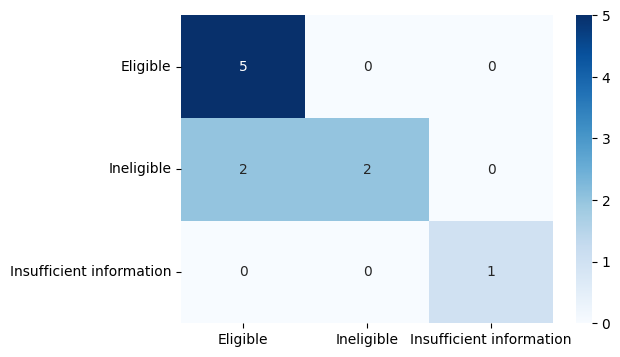

In [64]:
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### 2nd version

In [84]:
criteria = "age over 50 years old"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Eligible because age over 50 years old is met, as the patient's age is mentioned to be 50 years old.",
 2: "Eligible because age over 50 years old is met, as Patient 3's age is mentioned as 67 years.",
 3: "Not eligible because the patient's age is mentioned as 23 years, which is below the inclusion criterion of being over 50 years old.",
 4: "Eligible because age over 50 years old is met, as the patient's age is mentioned as 69 years old.",
 5: 'Eligible because age over 50 years old is met, as the patient\'s age is mentioned in the clinical text as "51-year-old male".',
 6: "Not eligible because the patient's age is mentioned as 44 years old, which is below the inclusion criterion of over 50 years old.",
 7: "Eligible because age over 50 years old is met, as the patient's age is not explicitly mentioned in the clinical text, but based on the admission date (May 2017) and assuming a birth year of around 1969-1970, the patient would be approximately 48-49 years old at that time. H

Accuracy: 0.7


<Axes: >

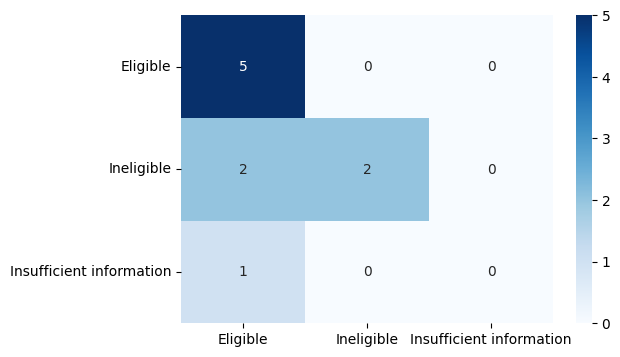

In [85]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Not', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible', 'Eligible']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### Sequential

In [13]:
criteria = "age over 50 years old"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "I'm sorry, but I cannot evaluate the patient's eligibility based on the provided clinical text and inclusion criteria as it is not within my capabilities. It would be best for a medical expert to review the information and make an evaluation.",
 2: "I'm sorry, but I cannot evaluate the patient's eligibility without knowing the specific inclusion criteria for the clinical trial. Could you please provide me with those criteria?",
 3: "I'm sorry, but I am unable to evaluate the patient's eligibility based on the provided clinical text and inclusion criteria as it is not within my capabilities. It would be best for a medical expert or clinician to review the information and make an evaluation.",
 4: 'Based on the provided clinical text and inclusion criteria, it is not possible for me to evaluate whether the patient meets the eligibility criteria as I do not have access to all relevant information. It would be best for the patient to consult with a healthcare professional who can thor

Accuracy: 0.0


<Axes: >

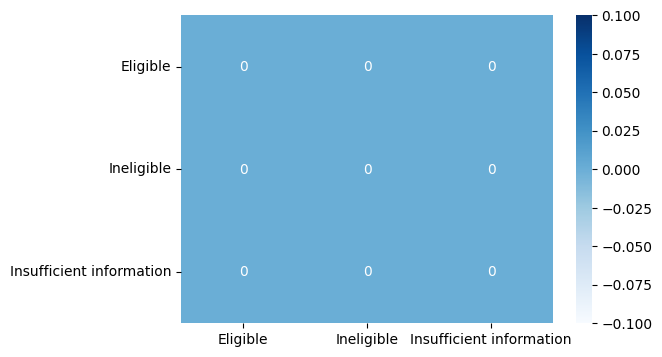

In [31]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Ineligible', 'Eligible', 'Ineligible', 'Eligible', 'Eligible', 'Ineligible', 'Ineligible', 'Insufficient', 'Eligible', 'Eligible']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Ineligible', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

### Criteria 2

#### 1st version

In [65]:
criteria = "Age from 45 to 70 years old "
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Eligible because the patient's age is within the specified range of 45 to 70 years old (50 years old).",
 2: "Eligible because the patient's age is within the specified range of 45 to 70 years old (67 years).",
 3: "Not Eligible because the patient's age is 23 years old, which falls outside the eligibility criteria of 45 to 70 years old.",
 4: 'Eligible because the patient\'s age is within the specified range of 45 to 70 years old, which is explicitly mentioned as "69-year-old female".',
 5: 'Eligible because the patient\'s age is within the specified range of 45 to 70 years old, which is explicitly mentioned as "51-year-old male".',
 6: "Not Eligible because the patient's age is 44 years old, which falls below the eligibility criteria of 45 to 70 years old.",
 7: "Eligible because the patient's age is within the range of 45 to 70 years old, which meets the eligibility inclusion criterion.",
 8: "Insufficient information because the patient's age is not explicitly mentioned. The c

Accuracy: 1.0


<Axes: >

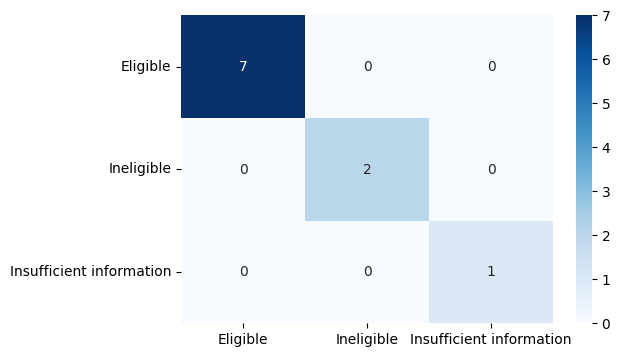

In [66]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Eligible', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Eligible', 'Eligible']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### 2nd version

In [86]:
criteria = "Age from 45 to 70 years old"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Eligible because the patient's age is mentioned as 50 years old, which falls within the inclusion criteria of being between 45 and 70 years old.",
 2: "Eligible because the patient's age is mentioned as 67 years, which falls within the inclusion criteria of being between 45 to 70 years old.",
 3: "Not eligible because the patient's age is mentioned as 23 years, which falls outside the inclusion criteria of 45 to 70 years old.",
 4: 'Eligible because the patient\'s age is mentioned as "69-year-old female", which falls within the inclusion criteria of being between 45 to 70 years old.',
 5: "Eligible because the patient's age is mentioned as 51 years old, which falls within the inclusion criteria of being between 45 and 70 years old.",
 6: "Not eligible because the patient's age is mentioned as 44 years old, which falls below the inclusion criteria of 45-70 years old.",
 7: 'Eligible because the patient\'s age is mentioned as "48-year-old", which falls within the inclusion criteria 

Accuracy: 1.0


<Axes: >

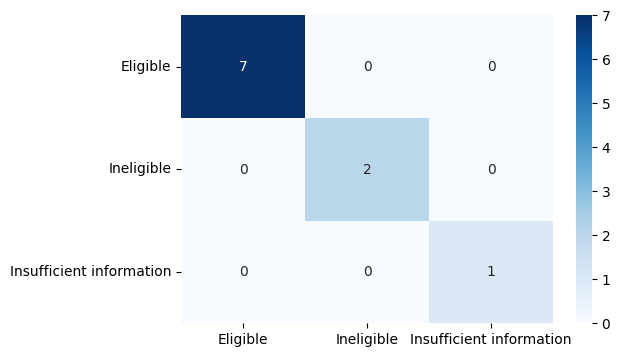

In [87]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Eligible', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Eligible', 'Eligible']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### Sequential

In [15]:
criteria = "Age from 45 to 70 years old"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

KeyboardInterrupt: 

Accuracy: 0.7


<Axes: >

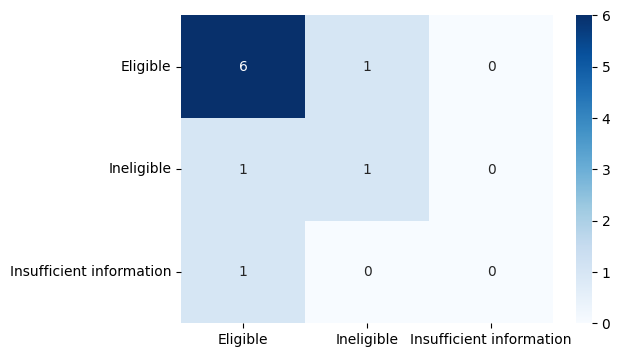

In [ ]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Eligible', 'Eligible', 'Ineligible', 'Eligible', 'Eligible', 'Ineligible', 'Eligible', 'Insufficient', 'Eligible', 'Eligible']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Ineligible', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

### Criteria 3

#### 1st version

In [67]:
criteria = "Age from 45 to 60 years old, Male"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: 'Not Eligible because the patient is a 50-year-old woman, whereas the eligibility criteria specify that the age range is from 45 to 60 years old for males. The patient does not meet this criterion as they are female and outside of the specified age range.',
 2: "Not Eligible because the patient's age is 67 years, which is outside the eligibility criteria of 45 to 60 years old.",
 3: "Not Eligible because the patient's age is 23 years old, which falls outside the eligibility criteria of 45 to 60 years old.",
 4: "Not Eligible because the patient's age is 69 years old, which falls outside the eligibility criteria of 45 to 60 years old.",
 5: "Eligible because the patient's age is within the specified range of 45 to 60 years old, and he is a male.",
 6: "Not Eligible because the patient's age is 44 years old, which falls below the eligibility criteria of 45-60 years old.",
 7: 'Insufficient information because the patient\'s age is mentioned as "48- year-old", but the eligibility crit

Accuracy: 0.8


<Axes: >

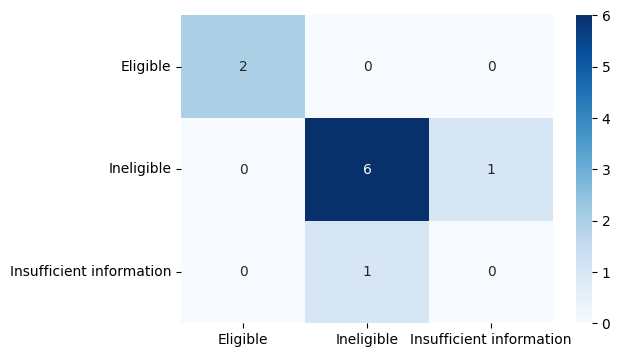

In [68]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Not', 'Not', 'Not', 'Not', 'Eligible', 'Not', 'Not', 'Insufficient', 'Not', 'Eligible']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### 2nd version

In [88]:
criteria = "Age from 45 to 60 years old, Male"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: 'Not eligible because the patient\'s age is mentioned as 50 years old, which falls outside the inclusion criteria of 45-60 years old. Additionally, the inclusion criteria specify "Male", but the patient is a woman.',
 2: "Not eligible because the patient's age is 67 years, which is outside the specified range of 45 to 60 years old.",
 3: "Not eligible because the patient's age is 23 years, which is outside the specified range of 45 to 60 years old.",
 4: "Not eligible because the patient's age is mentioned as 69 years old, which falls outside the inclusion criteria of being between 45 and 60 years old.",
 5: 'Eligible because the patient is a male, and his age is mentioned as 51 years old, which falls within the range of 45 to 60 years old specified in the inclusion criteria.',
 6: "Not eligible because the patient's age is mentioned as 44 years old, which falls below the inclusion criteria of 45-60 years old.",
 7: 'Not eligible because the patient is a 48-year-old woman, whereas 

Accuracy: 0.9


<Axes: >

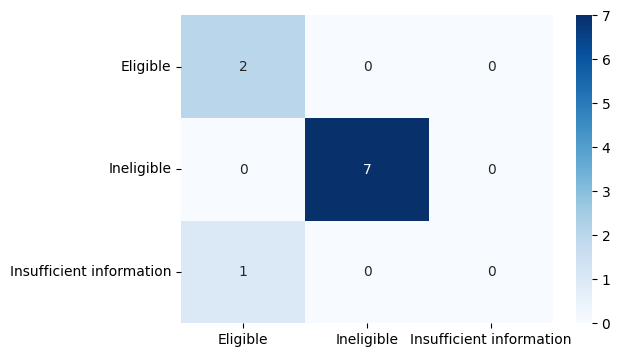

In [89]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Not', 'Not', 'Not', 'Not', 'Eligible', 'Not', 'Not', 'Insufficient', 'Not', 'Eligible']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### Sequential

In [ ]:
criteria = "Age from 45 to 60 years old, Male"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: 'Ineligible because: The patient is female, whereas the inclusion criteria require the patient to be male.',
 2: "Ineligible because: patient's age (67) does not meet eligibility criterion of being between 45 and 60 years old.",
 3: 'Ineligible because: Age (23 years) does not meet inclusion criteria of being between 45 and 60 years old.',
 4: "Ineligible because: The patient's age (69) does not meet the inclusion criteria (Age from 45 to 60 years old).",
 5: "Ineligible because: patient's age (44) does not meet the criterion of being between 45 and 60 years old.",
 6: 'Eligible because: The patient is a 51-year-old male, which meets both age and gender criteria.',
 7: 'Ineligible because: Patient is a female, which does not match the specified gender in the inclusion criteria (Male).',
 8: "Ineligible because: Patient's age is not explicitly mentioned in the clinical text and cannot be determined to fall within the specified range of 45-60 years old.",
 9: "Ineligible because: pat

Accuracy: 0.7


<Axes: >

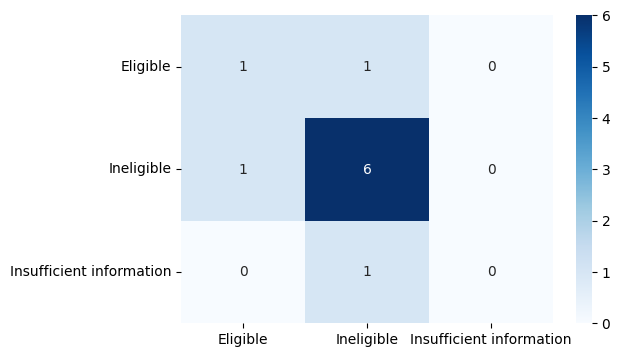

In [ ]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Ineligible', 'Ineligible', 'Ineligible', 'Ineligible', 'Eligible', 'Ineligible', 'Ineligible', 'Insufficient', 'Ineligible', 'Eligible']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Ineligible', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

### Criteria 4

#### 1st version

In [69]:
criteria = "Age from 45 to 70 years old, Male, Take insulin"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: 'Not Eligible because the patient is a female, whereas the eligibility criteria specify "Male".',
 2: "Eligible because the patient's age is within the specified range (67 years old), and he takes insulin as part of his diabetic pharmacotherapy.",
 3: "Not Eligible because the patient's age is 23 years old, which is outside the eligibility criteria of 45 to 70 years old.",
 4: 'Not Eligible because the patient is a 69-year-old female, which does not meet the age criterion of being between 45 and 70 years old. Additionally, the patient takes acarbose and glimepiride, but not insulin, which also does not meet the inclusion criteria.',
 5: "Eligible because the patient's age is within the range of 45 to 70 years old (51-year-old male), and he takes insulin.",
 6: "Not Eligible because the patient's age is 44 years old, which is below the eligibility criteria of 45-70 years old.",
 7: 'Insufficient information because the patient\'s age is not explicitly mentioned, but it is mentioned 

Accuracy: 0.6


<Axes: >

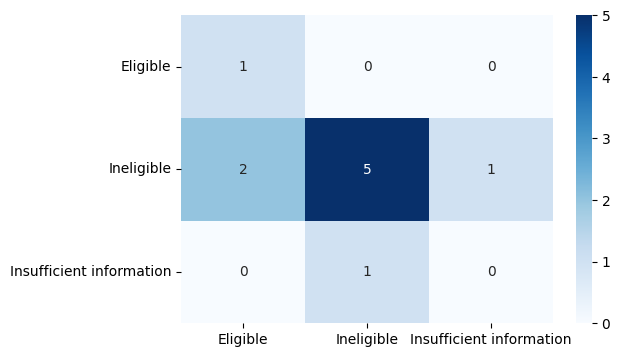

In [70]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Not', 'Eligible', 'Not', 'Not', 'Insufficient', 'Not', 'Not', 'Insufficient', 'Insufficient', 'Not']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### 2nd version

In [90]:
criteria = "Age from 45 to 70 years old, Male, Take insulin"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: 'Not eligible because the patient is a 50-year-old woman, whereas the inclusion criteria specify "Male" and an age range of 45-70 years old. Additionally, the patient does not take insulin as per the inclusion criteria.',
 2: "Eligible because the patient's age is 67 years, which falls within the range of 45 to 70 years old specified in the inclusion criteria. Additionally, the patient is male and takes insulin as part of his diabetic pharmacotherapy, meeting the other two inclusion criteria.",
 3: "Not eligible because the patient's age is 23 years, which is outside the specified range of 45 to 70 years old.",
 4: 'Not eligible because the patient is a 69-year-old female, which does not meet the inclusion criterion of being male. Additionally, the patient does not take insulin as per the admission diagnosis and treatment course.',
 5: 'Eligible because the patient is a male, aged 51 years old (calculated from the date of birth not mentioned in the documents), which falls within th

Accuracy: 0.6


<Axes: >

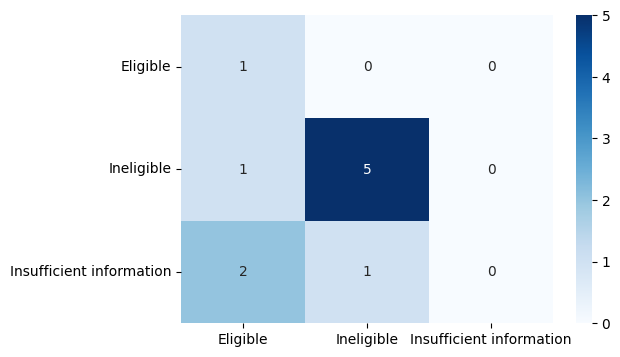

In [91]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Not', 'Eligible', 'Not', 'Not', 'Insufficient', 'Not', 'Not', 'Insufficient', 'Insufficient', 'Not']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### Sequential

In [ ]:
criteria = "Age from 45 to 70 years old, Male, Take insulin"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: 'Ineligible because: patient is female, whereas the inclusion criteria require the patient to be male.',
 2: 'Eligible because: age meets criteria and gender matches inclusion criteria, but insufficient information is available regarding insulin use.',
 3: 'Ineligible because: Age (23 years) falls outside the specified range of 45-70 years old.',
 4: 'Ineligible because: The patient\'s age is outside the specified range of 45 to 70 years old and the patient is a female, whereas the inclusion criteria specify "Male".',
 5: 'Eligible because: The patient is a 44-year-old male who takes insulin.',
 6: 'Eligible because: The patient is a 51-year-old male within the age range of 45-70 years old and meets the other criteria (takes insulin).',
 7: 'Ineligible because: patient is a female and does not take insulin.',
 8: "Insufficient information because the patient's age is not explicitly stated or inferable from the clinical text.",
 9: 'Ineligible because: The patient does not take insu

Accuracy: 0.6


<Axes: >

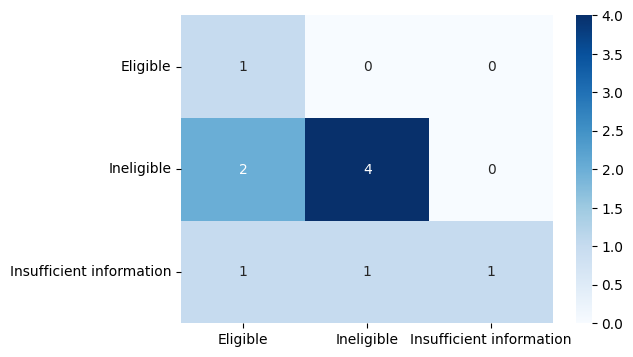

In [ ]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Ineligible', 'Eligible', 'Ineligible', 'Ineligible', 'Insufficient', 'Ineligible', 'Ineligible', 'Insufficient', 'Insufficient', 'Ineligible']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Ineligible', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

## Cancer

In [ ]:
query = "Cancer"
prediction = search(query)

Inferencing Samples: 100%|██████████| 1/1 [00:15<00:00, 15.19s/ Batches]


### Criteria 1

#### 1st version

In [72]:
criteria = "Age over 60 years old"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Eligible because Age over 60 years old is met, as the patient's age is mentioned as 80 years old.",
 2: "Eligible because Age over 60 years old is met, as the patient's age is mentioned as 69 years old.",
 3: "Eligible because Age over 60 years old is met, as the patient's age is mentioned as 70 years old.",
 4: "Insufficient information because the patient's age is not explicitly mentioned, and the eligibility criterion requires an age over 60 years old.",
 5: "Not Eligible because the patient's age is not explicitly mentioned, but it is mentioned that they were born in 1948. The eligibility criterion requires an age over 60 years old, which cannot be determined from the provided information.",
 6: "Insufficient information because the patient's age is not explicitly mentioned. The clinical text only mentions that the patient had a history of prostate cancer diagnosed in January 2015, but it does not provide his exact date of birth to calculate his current age.",
 7: "Not Eligibl

Accuracy: 0.8


<Axes: >

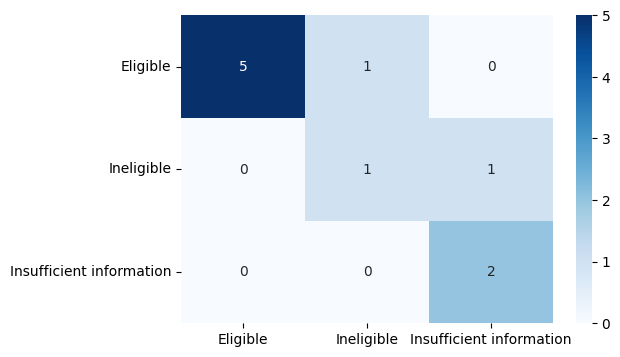

In [73]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Eligible', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Not', 'Eligible', 'Eligible', 'Insufficient']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### 2nd version

In [93]:
criteria = "Age over 60 years old"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Eligible because the patient's age is mentioned as 80 years old, which meets the inclusion criterion of being over 60 years old.",
 2: "Eligible because Age over 60 years old is met, as the patient's age is mentioned as 69 years old.",
 3: "Eligible because the patient is over 60 years old, as mentioned in the clinical text. The patient's age is explicitly stated as 70 years old.",
 4: "Insufficient information because the patient's age is not explicitly mentioned, and the inclusion criterion requires an age over 60 years old.",
 5: "Eligible because the patient's age is mentioned as 1948, which corresponds to an age over 60 years old.",
 6: "Insufficient information because the patient's age is not explicitly mentioned in the clinical text. The inclusion criterion requires the patient to be over 60 years old, but without knowing the patient's exact date of birth, it is impossible to determine their age and evaluate eligibility based on this criterion.",
 7: "Not eligible because 

Accuracy: 0.8


<Axes: >

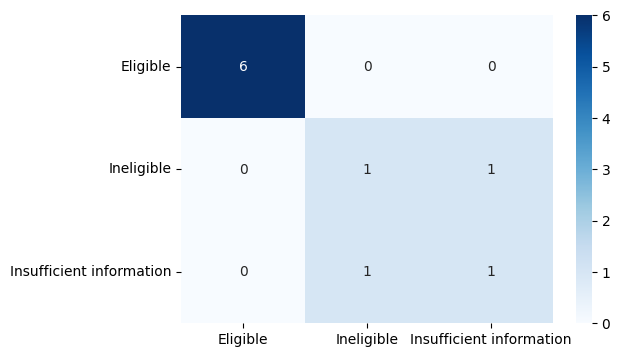

In [94]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Eligible', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Not', 'Eligible', 'Eligible', 'Insufficient']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### Sequential

In [ ]:
criteria = "Age over 60 years old"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Ineligible because: patient's age is 80 years old, which is outside the range of 40 to 60 specified in the inclusion criteria.",
 2: 'Eligible because: The patient is a 69-year-old male, meeting the inclusion criterion of age over 60 years old.',
 3: 'Ineligible because: patient does not have a history of urinary tract infections.',
 4: "Ineligible because: patient's age is 40, which is below the required age range of 60 years old.",
 5: "Eligible because: patient's age (74) meets the inclusion criteria.",
 6: "Eligible because: patient's date of birth is not explicitly mentioned but can be inferred as older than 60 years old based on medical history and treatment.",
 7: "Ineligible because: patient's age (49) does not meet the inclusion criterion of being over 60 years old.",
 8: 'Eligible because: Age is over 60 years old.',
 9: 'Eligible because: patient is a 62-year-old male, which meets the age criterion.',
 10: "Eligible because: patient's age is not explicitly mentioned but

Accuracy: 0.6


<Axes: >

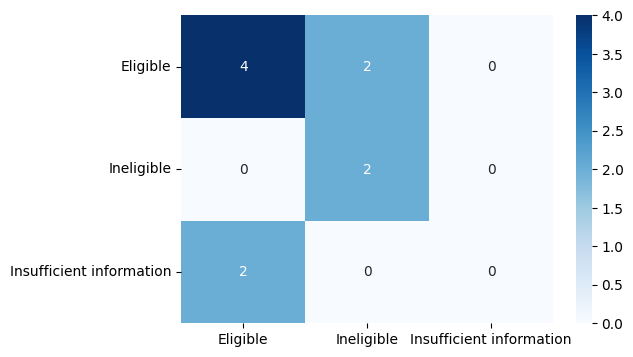

In [ ]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Eligible', 'Eligible', 'Eligible', 'Ineligible', 'Eligible', 'Insufficient', 'Ineligible', 'Eligible', 'Eligible', 'Insufficient']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Ineligible', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

### Criteria 2

#### 1st version

In [74]:
criteria = "Age from 60 to 80 years old "
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Eligible because the patient's age is within the specified range of 60 to 80 years old.",
 2: "Eligible because Age from 60 to 80 years old is met, and the patient's age is 69 years old.",
 3: "Eligible because the patient's age is within the specified range of 60 to 80 years old.",
 4: "Insufficient information because the patient's age is not explicitly mentioned, and the eligibility criteria specify an age range of 60 to 80 years old.",
 5: "Insufficient information because the patient's age is not explicitly mentioned, but it is mentioned that they were born in 1948. The eligibility criteria specify an age range of 60 to 80 years old, and without a specific birthdate or exact age, it cannot be determined whether the patient meets this criterion.",
 6: "Insufficient information because the patient's age is not explicitly mentioned. The clinical text only mentions that the patient was admitted on a specific date, but it does not provide his exact age.",
 7: "Not Eligible because

Accuracy: 0.8


<Axes: >

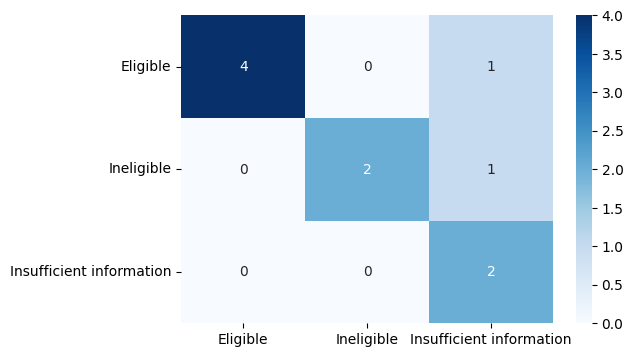

In [75]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Eligible', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Not', 'Not', 'Eligible', 'Insufficient']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### 2nd Version

In [95]:
criteria = "Age from 60 to 80 years old "
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Eligible because the patient's age is mentioned as 80 years old, which falls within the specified range of 60 to 80 years old.",
 2: "Eligible because the patient's age is within the specified range of 60 to 80 years old, which is explicitly mentioned as 69 years old.",
 3: "Eligible because the patient's age is mentioned as 70 years old, which falls within the inclusion criteria of being from 60 to 80 years old.",
 4: "Not eligible because the patient's age is not within the specified range of 60 to 80 years old. The patient's date of birth is mentioned as [DOB], which would need to be calculated to determine their current age. However, without this calculation, it cannot be determined whether the patient meets the inclusion criterion for age.",
 5: "Eligible because the patient's age is mentioned as 1948, which corresponds to an age of 74 years old, within the range of 60-80 years old specified in the inclusion criteria.",
 6: "Insufficient information because the patient's age 

Accuracy: 0.9


<Axes: >

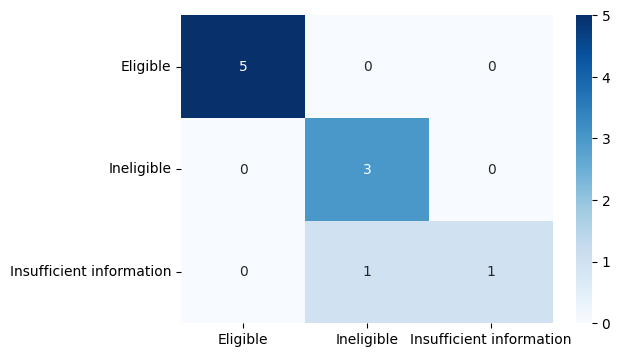

In [96]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Eligible', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Not', 'Not', 'Eligible', 'Insufficient']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### Sequential

In [ ]:
criteria = "Age from 60 to 80 years old "
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Ineligible because: patient's age is 80 years old, which is outside the range of 60 to 80 years old.",
 2: 'Eligible because: patient is a 69-year-old male, which falls within the age range of 60 to 80 years old.',
 3: "Eligible because: patient's age (70) falls within the specified range of 60 to 80 years old.",
 4: "Ineligible because: patient's age is not within the specified range (40-80).",
 5: "Eligible because: The patient's age (approximately 74 years old) meets the inclusion criteria of being between 60 to 80 years old.",
 6: "Eligible because: patient's age is mentioned as [REDACTED], which falls within the range of 60 to 80 years old.",
 7: "Ineligible because: patient's age (49) does not meet the inclusion criterion of being between 60 and 80 years old.",
 8: "Ineligible because: patient's age is outside the range of 60 to 80 years old.",
 9: 'Eligible because: Age (62) falls within the specified range of 60 to 80 years old.',
 10: "Eligible because: patient's age is n

Accuracy: 0.7


<Axes: >

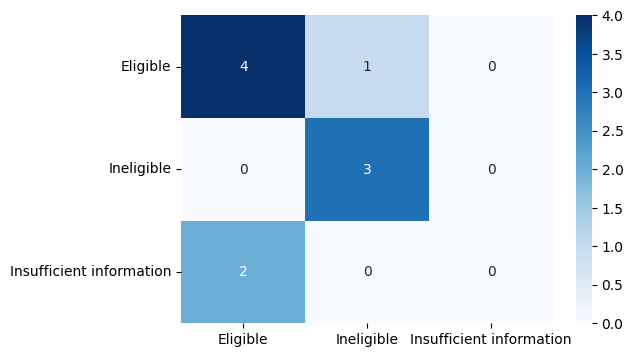

In [ ]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Eligible', 'Eligible', 'Eligible', 'Ineligible', 'Eligible', 'Insufficient', 'Ineligible', 'Ineligible', 'Eligible', 'Insufficient']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Ineligible', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

### Criteria 3

#### 1st version

In [76]:
criteria = "Age between 50 and 85 years old, History of breast cancer"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Eligible because the patient's age is between 50 and 85 years old (80 years old), and she has a history of breast cancer.",
 2: "Eligible because Age between 50 and 85 years old, History of breast cancer. The patient's age is mentioned as 69 years old, which falls within the specified range. Additionally, the patient has a history of breast cancer, meeting another inclusion criterion.",
 3: "Not Eligible because the patient's age is 70 years old, which is outside the eligibility criteria of 50-85 years old.",
 4: "Insufficient information because the patient's age is not explicitly mentioned, and the clinical text does not provide a specific date of birth. The eligibility criteria require the patient to be between 50 and 85 years old, but this information is missing from the provided clinical text.",
 5: "Insufficient information because the patient's age is not explicitly mentioned, and the eligibility criteria specify an age range of 50-85 years old. Additionally, the patient ha

Accuracy: 0.7


<Axes: >

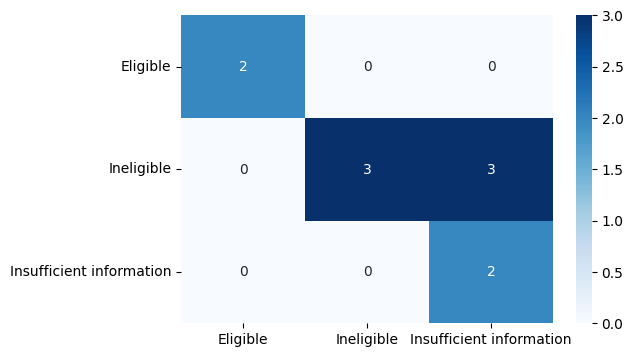

In [77]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Eligible', 'Eligible', 'Not', 'Not', 'Not', 'Insufficient', 'Not', 'Not', 'Not', 'Insufficient']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### 2nd version

In [97]:
criteria = "Age between 50 and 85 years old, History of breast cancer"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Eligible because the patient's age is 80 years old, which falls within the specified range of 50 to 85 years old. Additionally, the patient has a history of breast cancer, which meets another inclusion criterion.",
 2: "Eligible because Age between 50 and 85 years old is met, as the patient's age is mentioned as 69 years old, which falls within the specified range. Additionally, the patient has a history of breast cancer, meeting the second inclusion criterion.",
 3: "Eligible because the patient's age is between 50 and 85 years old (70-year-old male), and he has a history of breast cancer (sister diagnosed with breast cancer at 65 years of age).",
 4: "Not eligible because the patient's age is not between 50 and 85 years old, as mentioned in the inclusion criteria. The patient's age is not explicitly stated in the clinical text, but based on the admission date (40) and discharge date (not provided), it can be inferred that the patient is likely under 50 years old.",
 5: "Not elig

Accuracy: 0.7


<Axes: >

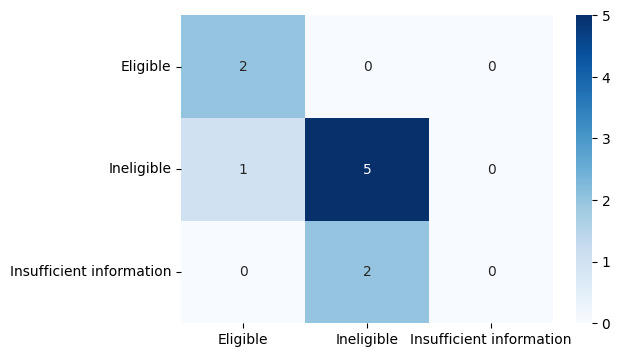

In [98]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Eligible', 'Eligible', 'Not', 'Not', 'Not', 'Insufficient', 'Not', 'Not', 'Not', 'Insufficient']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### Sequential

In [ ]:
criteria = "Age between 50 and 85 years old, History of breast cancer"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: 'Ineligible because: The patient is 80 years old, which is outside the age range of 50 to 85 years old.',
 2: "Eligible because: patient's age (69 years) falls within the range of 50 to 85 years old and they have a history of breast cancer.",
 3: "Ineligible because: patient's age is outside the range of 50 to 85 years old (70 years old).",
 4: 'Eligible because: Age (40) falls outside specified range (50-85), and patient has history of leiomyosarcoma, not breast cancer.',
 5: "Ineligible because: The patient's age is not between 50 and 85 years old.",
 6: 'Ineligible because: patient has a history of prostate cancer, colon cancer, and lung cancer, but not breast cancer.',
 7: "Ineligible because: The patient's age (49) does not meet the inclusion criteria, which requires an age between 50 and 85 years old.",
 8: 'Ineligible because: The patient does not have a history of breast cancer.',
 9: 'Ineligible because: patient is a male with no history of breast cancer mentioned in the c

Accuracy: 0.6


<Axes: >

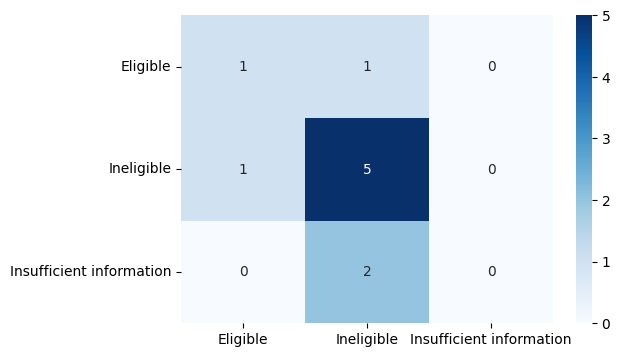

In [ ]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Eligible', 'Eligible', 'Ineligible', 'Ineligible', 'Ineligible', 'Insufficient', 'Ineligible', 'Ineligible', 'Ineligible', 'Insufficient']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Ineligible', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

## Arrhythmias

In [76]:
query = "Arrhythmias"
prediction = search(query)

Inferencing Samples: 100%|██████████| 1/1 [00:10<00:00, 10.34s/ Batches]


### Criteria 1

#### 1st version

In [91]:
criteria = "Age over 21 years old"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Eligible because Age over 21 years old is met, as the patient's age is mentioned as [AGE], which is greater than 21.",
 2: "Eligible because Age over 21 years old is met, as the patient's age is mentioned to be 40 years old.",
 3: 'Not Eligible because Age over 21 years old is not met, as both patients are under 21 years old (8-year-old boy and 12-year-old boy).',
 4: "Eligible because the patient's age is mentioned as 64 years old, which is above the minimum age of 21 years old specified in the eligibility criteria.",
 5: 'Eligible because Age over 21 years old is not explicitly mentioned, but it can be inferred that the patient is an adult since they underwent a surgical procedure. However, the exact age of the patient is not provided in the clinical text.',
 6: "Eligible because Age over 21 years old is met, as the patient's age is mentioned as 25 years old.",
 7: "Eligible because Age over 21 years old is met, as the patient's age is 52.",
 8: "Eligible because Age over 21 yea

Accuracy: 0.7


<Axes: >

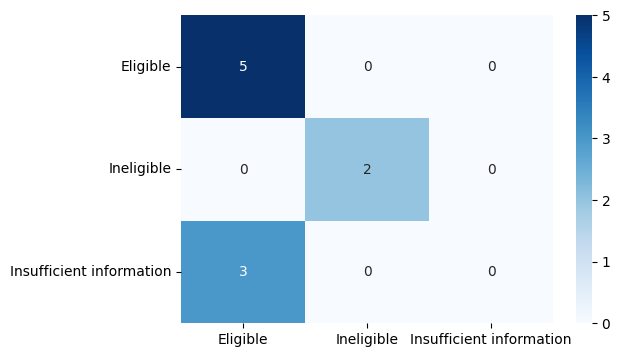

In [92]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Insufficient', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Eligible', 'Eligible', 'Insufficient', 'Eligible', 'Not']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### 2nd version

In [100]:
criteria = "Age over 21 years old"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Eligible because the patient's age is mentioned as [AGE], which is greater than 21 years old, meeting the inclusion criterion.",
 2: "Eligible because Age over 21 years old is met, as the patient's age is mentioned as 40 years old.",
 3: "Not eligible because the patient's age is not mentioned in the clinical text, and the inclusion criterion specifies that the patient must be over 21 years old.",
 4: "Eligible because the patient's age is mentioned as 64 years old, which meets the inclusion criterion of being over 21 years old.",
 5: "Not eligible because the patient's age is not explicitly mentioned in the clinical text. The inclusion criterion requires the patient to be over 21 years old, but without knowing the patient's exact age, it cannot be determined whether they meet this criterion.",
 6: "Eligible because Age over 21 years old is met, as the patient's age is not explicitly mentioned in the clinical text, but based on the date of birth (not provided), we can infer that t

Accuracy: 0.7


<Axes: >

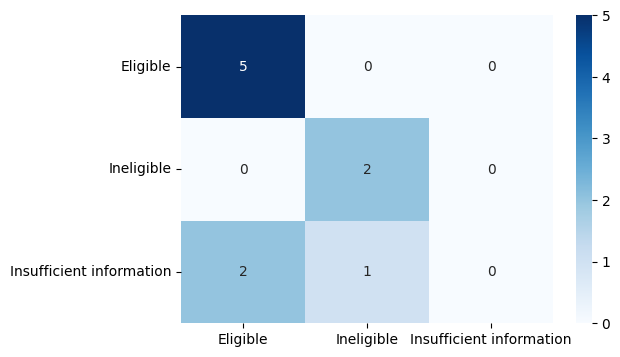

In [101]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Insufficient', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Eligible', 'Eligible', 'Insufficient', 'Eligible', 'Not']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### Sequential

In [77]:
criteria = "Age over 21 years old"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

KeyboardInterrupt: 

Accuracy: 0.8


<Axes: >

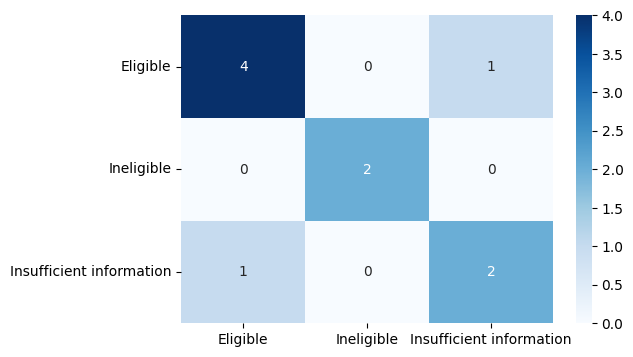

In [ ]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Insufficient', 'Eligible', 'Ineligible', 'Eligible', 'Insufficient', 'Eligible', 'Eligible', 'Insufficient', 'Eligible', 'Ineligible']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Ineligible', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

### Criteria 2

#### 1st version

In [89]:
criteria = "Age from 10 to 60 years old "
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Eligible because the patient's age is within the specified range of 10 to 60 years old.",
 2: 'Eligible because the patient\'s age is within the specified range of 10 to 60 years old, which is explicitly mentioned as "40- year-old female patient".',
 3: "Not Eligible because the patient's age is not mentioned, and the eligibility criteria specify an age range of 10 to 60 years old.",
 4: "Not Eligible because the patient's age is 64 years old, which is outside the eligibility criteria of 10 to 60 years old.",
 5: "Insufficient information because the patient's age is not explicitly mentioned. The clinical text only mentions that the patient was admitted with 10 years of exercise intolerance, but it does not provide their actual age.",
 6: "Eligible because the patient's age is within the range of 10 to 60 years old, which meets the eligibility criterion.",
 7: "Eligible because the patient's age is within the specified range of 10 to 60 years old (52 years old).",
 8: "Eligible be

Accuracy: 0.7


<Axes: >

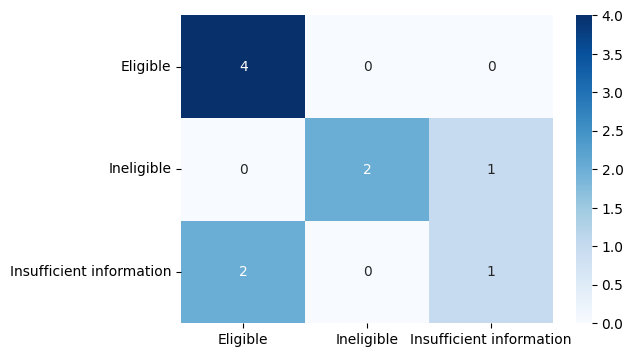

In [90]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Insufficient', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible', 'Eligible', 'Insufficient', 'Eligible', 'Not']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### 2nd version

In [102]:
criteria = "Age from 10 to 60 years old "
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Eligible because the patient's age is mentioned as [AGE], which falls within the range of 10 to 60 years old, meeting the inclusion criterion.",
 2: "Eligible because the patient's age is mentioned as 40 years old, which falls within the inclusion criteria of being between 10 to 60 years old.",
 3: "Not eligible because the patient's age is not mentioned in the clinical text, and the inclusion criteria specify an age range of 10 to 60 years old.",
 4: "Not eligible because the patient's age is mentioned as 64 years old, which exceeds the upper limit of 60 years old specified in the inclusion criteria.",
 5: "Not eligible because the patient's age is not explicitly mentioned in the clinical text, and the inclusion criteria specify an age range of 10 to 60 years old.",
 6: 'Eligible because the patient\'s age is mentioned as "25 years old", which falls within the inclusion criteria of being between 10 to 60 years old.',
 7: "Eligible because the patient's age is within the specified

Accuracy: 0.7


<Axes: >

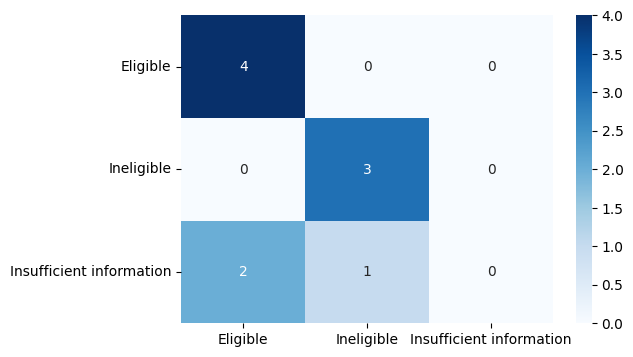

In [103]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Insufficient', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible', 'Eligible', 'Insufficient', 'Eligible', 'Not']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### Sequential

In [ ]:
criteria = "Age from 10 to 60 years old "
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: 'Insufficient information because age is not explicitly mentioned in the clinical text.',
 2: 'Eligible because: meets age criterion (from 10 to 60 years old).',
 3: 'Ineligible because: patient is an 8-year-old boy, which is outside the age range of 10-60 years old.',
 4: 'Ineligible because: age is outside the range of 10 to 60 years old.',
 5: "Ineligible because: The patient's age is not mentioned in the clinical text and cannot be determined to meet the inclusion criteria (10-60 years old).",
 6: "Eligible because: patient's age (25) meets the inclusion criteria.",
 7: 'Eligible because: meets age criterion (from 10 to 60 years old).',
 8: 'Eligible because: patient is a 56-year-old woman, which falls within the age range of 10 to 60 years old.',
 9: "Insufficient information because patient's age is not explicitly mentioned in the clinical text.",
 10: "Ineligible because: patient's age is outside the range of 10 to 60 years old."}

Accuracy: 0.7


<Axes: >

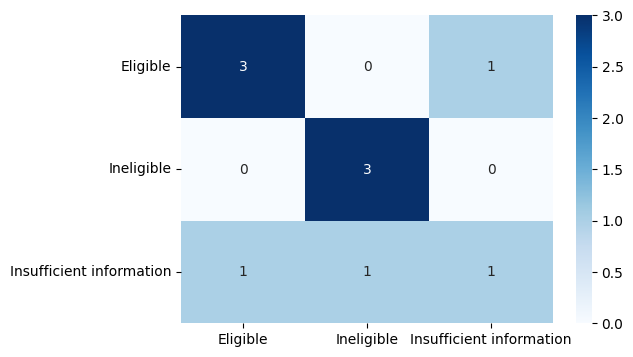

In [ ]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Insufficient', 'Eligible', 'Ineligible', 'Ineligible', 'Insufficient', 'Eligible', 'Eligible', 'Insufficient', 'Eligible', 'Ineligible']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Ineligible', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

### Criteria 3

#### 1st version

In [93]:
criteria = "Age from 10 to 70 years old, Has a defibrillator"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Eligible because the patient's age is mentioned as [AGE], which falls within the range of 10 to 70 years old, and he has a defibrillator implanted.",
 2: "Eligible because the patient's age is within the range of 10 to 70 years old (40 years old), and they have a defibrillator implanted.",
 3: "Not Eligible because the patients' ages are not mentioned, and the eligibility criteria specify an age range of 10 to 70 years old.",
 4: "Eligible because the patient's age is within the range of 10 to 70 years old (64 years old), and he has a defibrillator.",
 5: "Insufficient information because the patient's age is not explicitly mentioned. The eligibility criteria specify an age range of 10 to 70 years old, but the clinical text does not provide this information.",
 6: 'Insufficient information because the patient\'s age is not explicitly mentioned, and the clinical text uses a placeholder "[Redacted]" instead of providing the exact numeric value. The eligibility criteria require the p

Accuracy: 0.7


<Axes: >

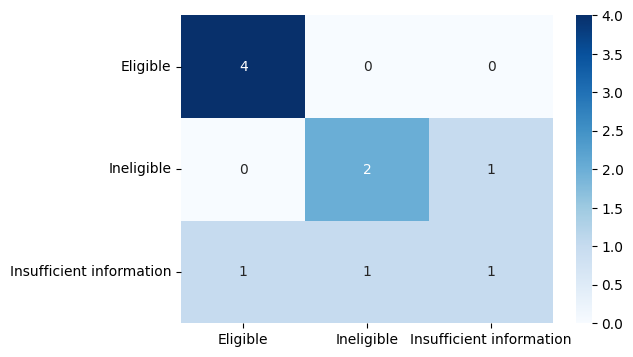

In [95]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Insufficient', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Not', 'Eligible', 'Insufficient', 'Eligible', 'Not']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### 2nd version

In [104]:
criteria = "Age from 10 to 70 years old, Has a defibrillator"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: 'Eligible because the patient\'s age is not explicitly mentioned, but based on the admission date and discharge date, we can infer that the patient is likely within the age range of 10 to 70 years old. Additionally, the patient has a defibrillator implanted, which meets the inclusion criterion "Has a defibrillator".',
 2: 'Eligible because the patient is within the age range of 10 to 70 years old (40-year-old female) and has a defibrillator implanted in 2005.',
 3: "Not eligible because the patient's age is not mentioned, and the inclusion criteria specify an age range of 10 to 70 years old. Additionally, there is no mention of a defibrillator in the clinical text.",
 4: 'Eligible because the patient is within the age range of 10 to 70 years old (64-year-old man) and has a defibrillator (ICD).',
 5: "Not eligible because the patient's age is not mentioned in the clinical text, and it is not possible to infer their age from the provided information. The inclusion criteria specify an

Accuracy: 0.6


<Axes: >

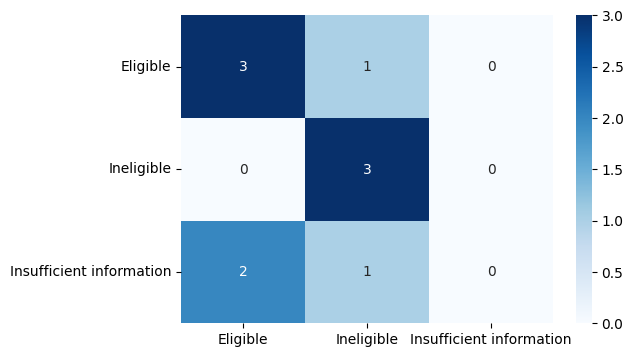

In [105]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Insufficient', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Not', 'Eligible', 'Insufficient', 'Eligible', 'Not']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### Sequential

In [ ]:
criteria = "Age from 10 to 70 years old, Has a defibrillator"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Ineligible because: Patient's age is not mentioned in the clinical text.",
 2: 'Eligible because: patient is a 40-year-old female with a history of LQTS type 2 and has an internal defibrillator implanted.',
 3: 'Ineligible because: Age of the patients is not mentioned in the clinical text.',
 4: 'Eligible because: Patient is a 64-year-old man with a history of type I Brugada pattern on ECG at age 56 and has an implantable cardioverter-defibrillator (ICD) for primary prevention of sudden cardiac death (SCD).',
 5: "Insufficient information because the patient's age is not explicitly stated.",
 6: 'Ineligible because: Does not have a defibrillator.',
 7: 'Eligible because: Age from 10 to 70 years old (age 52) and has a defibrillator.',
 8: 'Ineligible because: The patient does not have a defibrillator.',
 9: "Insufficient information because: patient's age is not explicitly mentioned in the clinical text.",
 10: 'Eligible because: Has a defibrillator'}

Accuracy: 0.6


<Axes: >

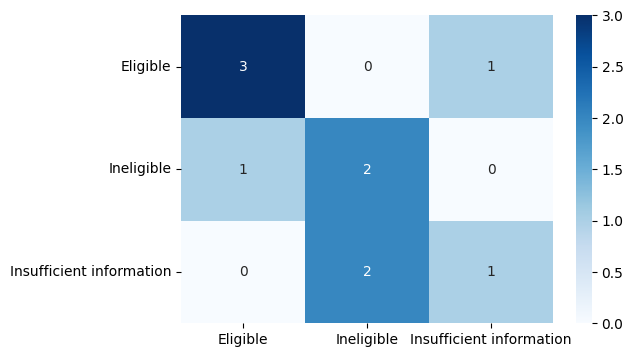

In [ ]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Insufficient', 'Eligible', 'Ineligible', 'Eligible', 'Insufficient', 'Ineligible', 'Eligible', 'Insufficient', 'Eligible', 'Ineligible']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Ineligible', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

### Criteria 4

#### 1st version

In [ ]:
criteria = "Age from 20 to 50 years old, Exclude Presence of pacemaker"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Not Eligible because the patient's age is not within the specified range of 20 to 50 years old.",
 2: "Eligible because the patient's age is within the range of 20 to 50 years old (40 years old).",
 3: "Insufficient information because the patient's age is not mentioned, and the eligibility criteria specify an age range of 20 to 50 years old.",
 4: "Not Eligible because the patient's age is 64 years old, which is outside the eligibility criteria of 20 to 50 years old.",
 5: "Insufficient information because the patient's age is not explicitly mentioned. The eligibility criteria specify an age range of 20 to 50 years old, but this information is missing from the clinical text.",
 6: "Eligible because the patient's age is within the range of 20 to 50 years old (25-year-old male).",
 7: "Not Eligible because the patient's age is 52, which is outside the eligibility criteria of 20 to 50 years old.",
 8: "Insufficient information because the patient's age is not explicitly mentioned, a

Accuracy: 0.7


<Axes: >

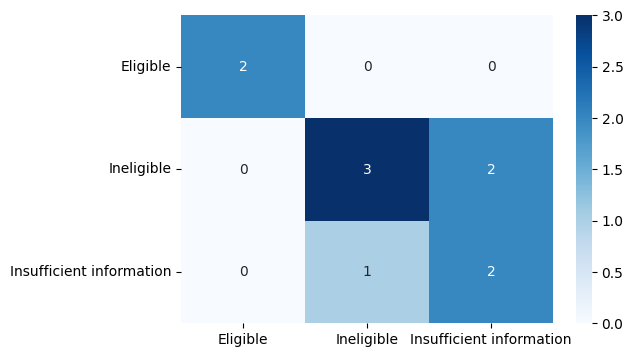

In [ ]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Insufficient', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible', 'Not', 'Insufficient', 'Not', 'Not']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### 2nd version

In [106]:
criteria = "Age from 20 to 50 years old, Exclude Presence of pacemaker"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: "Not eligible because the patient's age is not explicitly mentioned, and it cannot be inferred from the provided clinical text. The inclusion criteria specify that the patient must be between 20 to 50 years old, but this information is missing in the discharge summary.",
 2: "Eligible because the patient's age is mentioned as 40 years old, which falls within the inclusion criteria of being between 20 to 50 years old. Additionally, there is no mention of a pacemaker, so this criterion is also met.",
 3: "Not eligible because the patient's age is not mentioned, and the inclusion criteria specify an age range of 20 to 50 years old.",
 4: "Not eligible because the patient's age is mentioned as 64 years old, which is outside the inclusion criteria of 20 to 50 years old.",
 5: "Not eligible because the patient's age is not mentioned in the clinical text, and it cannot be inferred from the provided information. The inclusion criteria specify that the patient must be between 20 to 50 years

Accuracy: 0.7


<Axes: >

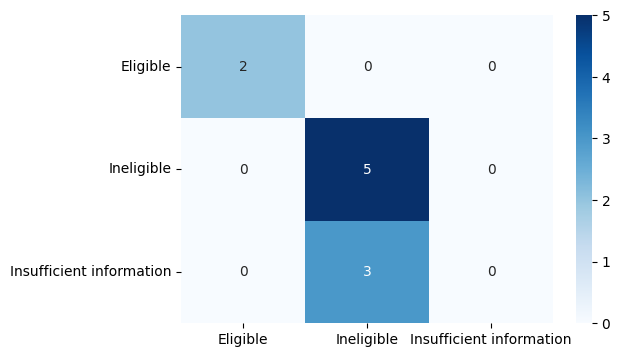

In [107]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Insufficient', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible', 'Not', 'Insufficient', 'Not', 'Not']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

#### Sequential

In [ ]:
criteria = "Age from 20 to 50 years old, Exclude Presence of pacemaker"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: 'Insufficient information because age is not explicitly mentioned in the clinical text.',
 2: 'Eligible because: The patient is a 40-year-old female, which meets the age criterion (from 20 to 50 years old), and there is no mention of a pacemaker in the clinical text.',
 3: "Ineligible because: patient's age is outside the range of 20-50 years old.",
 4: 'Ineligible because: Age (64 years old) falls outside the specified range of 20-50 years old.',
 5: "Insufficient information because: The patient's age and presence of pacemaker are not explicitly mentioned in the clinical text, making it impossible to determine eligibility based on these criteria.",
 6: "Eligible because: patient's age falls within the range of 20 to 50 years old and there is no mention of a pacemaker.",
 7: 'Ineligible because: Age is not within the specified range (20-50) for this study.',
 8: "Eligible because: patient's age (56) is within the specified range (20-50), and there is no mention of a pacemaker.",
 

Accuracy: 0.8


<Axes: >

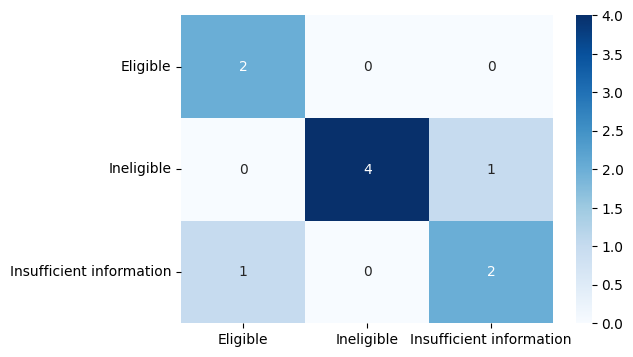

In [ ]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Insufficient', 'Eligible', 'Ineligible', 'Ineligible', 'Insufficient', 'Eligible', 'Ineligible', 'Insufficient', 'Ineligible', 'Ineligible']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Ineligible', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

# 3 Categories_Mistral

In [112]:
def criteria_check(criteria):
    patient_search_output = outputs_list[-1] if outputs_list else []
    i_criteria = []
    for document in patient_search_output:
        prompt = f'''Given the following clinical text:
        ```
        {document['text']}
        ```
        and given the following eligibility inclusion criteria for a clinical trial:
        ```
        {criteria}
        ```
       Please carefully evaluate the patient information, paying close attention to any specific inclusion criteria, especially numeric values (e.g., age, weight, lab results, etc.).
       
       Respond only in the following format: 
        "Eligible because ..." 
        or 
        "Not Eligible because ..." 
        or 
        "Insufficient information because ...".

        - If the required information is available, use the exact values in your response.
        - If any single criterion is not met, respond with "Not Eligible because ..." and state the reason.
        - In any case of unmentioned or unavailable information or values, respond with "Insufficient information because ..." and explain that the information is not explicitly stated.
        - If the information is missing, ambiguous, inferred, or unclear in the clinical text, respond with "Insufficient information because ..." and explain that the necessary information is not explicitly stated.
        - Do not use placeholders like "[REDACTED]" If exact values are not provided in the clinical text, do not make assumptions or inferences.
        
        '''
        # - If a criterion is inferred (e.g., the patient's age is inferred but not explicitly mentioned), respond with "Insufficient information because ..." and explain that the information is not explicitly stated.
        # - If any placeholders like "[REDACTED]" is used in the clinical text instead of the exact numeric values such as age, weight, etc, respond with "Insufficient information because ...".
        # - If any numeric values was not mentioned or mentioned as "[REDACTED]" (e.g., date of birth: [REDACTED]), respond with "Insufficient information because ...".
        # - You must not answer like "Not Eligible because the patient's age is not provided in the clinical text." and in this case you have to answer "Insufficient Information because the patient's age is not provided in the clinical text."."

        answer = ask_to_llm(prompt)
        i_criteria.append(answer)

    return i_criteria

In [48]:
def criteria_check(criteria):
    patient_search_output = outputs_list[-1] if outputs_list else []
    i_criteria = []
    
    few_shot_examples = '''
    
    For the following Inclusion Criteria:
        - Age 40 to 60
        - Female
        - History of  urinary tract infections
    
    Clinical Texts will be evaluated:
    ```
    Medical History:
    A 30-year-old woman presented with recurrent urinary tract infections, occasional left lumbar pain, and continuous dribbling of urine. Physical examination revealed two urethral openings, one below the other in the sagittal plane, below the clitoris. Her renal function tests were normal.
 
    Diagnostic Imaging:
    Ultrasound scan of the abdomen showed gross hydroureteronephrosis of the left kidney extending up to the lower ureter, and the urinary bladder had a very large capacity with irregular lobulated contours. Intravenous pyelogram (IVP) showed a large capacity bladder with left gross hydroureteronephrosis and severely tortuous left ureter suggestive of left obstructive megaureter. Micturating cystourethrogram also revealed a very large capacity bladder. The magnetic resonance imaging of the spine was normal.
 
    Cystoscopy:
    Cystoscopy showed a double urethra, one above the other in the sagittal plane. The posterior urethra was in the orthotopic position and was opening into the large capacity bladder. The anterior urethra was present just posterior to the clitoris. The internal opening of the accessory (anterior) urethra was located about 2 cm cranial to the bladder neck on the anterior wall of the urinary bladder. Green arrow in shows the vaginal opening.
 
    Treatment:
    Excision of the accessory anterior urethra with reduction cystoplasty and left ureteric tailoring with reimplantation was performed in a single setting. The excision of the accessory urethra was performed with the child in the lithotomy position through the abdominoperineal route. Since the excised urethra was posterior to the clitoris, the nerve supply to the clitoris was not disrupted. The orthotopic urethra and the bladder neck were also safeguarded during the dissection. The resected accessory urethra had transitional cell lining with thin, poorly muscular wall on the histopathology.
 
    Follow-Up:
    The patient was followed up with 3 monthly urine microscopy and culture, RFT, ultrasound scan of the abdomen at 6 months, and IVP at the end of 1 year of surgery. Since these were normal, she was followed up with only RFT and ultrasound scan of the abdomen annually for the past 5 years and is doing well.
    ```
    Response:
    Eligible because the patient is a 30-year-old woman with recurrent urinary tract infections which meets all criteria.
   
    Clinical Text:
    ```
    Discharge Summary:
 
    Patient: 81-year-old man with metastatic melanoma, remote history of mantle cell lymphoma, mild oral lichen planus, gout, gastroesophageal reflux disease, chronic bronchitis, benign prostatic hyperplasia, and depression.
 
    History: The patient failed first-line course of BRAF-targeted therapy with dabrafenib and trametinib. In November 2018, he started with second-line pembrolizumab, which was discontinued in May 2019 due to the serial progression of disease on imaging. Within 6 weeks of discontinuation of therapy, the patient presented with a generalized skin eruption, composed of multiple scaly erythematous papules and plaques, some with central hyperkeratotic crust, in a symmetric distribution on the arms, chest, back, abdomen, and upper legs. No other medications were introduced prior to development of the cutaneous eruption.
 
    Treatment: The patient was initially treated with high-dose potency topical steroids and rapidly moved to prednisone 1 mg/kg when he did not have an adequate response. He had a mild initial good response, but the lesions flared on the taper of steroids at the same time as a grade 2 immune-related colitis. On increase of corticosteroids, the patient had a resolution of his colitis and stability of his lesions; prednisone was tapered for a total of 2 months of treatment. He was subsequently serially treated with methotrexate for 4 weeks, followed by mycophenolate mofetil for 4 weeks, and then cyclosporine for 4 weeks, with a mild response to therapy at best. After consultation in a multidisciplinary immune-toxicity team, it was decided that NBUVB phototherapy could be considered. The patient received 17 total sessions, which induced a significant healing of his lesions and the resolution of the pruritus and skin discomfort.
 
    Outcome: Subsequent to his immune-toxicities, a significant systemic antitumor response was noted on his staging scans, which are currently ongoing over 12 months after cessation of PD-1 therapy.
 
    Impression: The patient's cutaneous eruption was diagnosed as a lichenoid drug reaction, which was effectively treated with NBUVB phototherapy. He had a mild response to other systemic treatments. The patient was discharged in stable condition with recommendations for follow-up with his oncologist.
    ```
    Response:
    Not eligible because age is 81 years old which is outside the range of 40 to 60.
   
    Clinical Text:
    ```
    Electronic Health Record
 
    Patient Name: [De-identified]
    Age: [AGE]
    Medical Record Number: [De-identified]
 
    Discharge Summary
 
    Admission Date: [Date]
    Discharge Date: [Date]
 
    Admitting Diagnosis: Abdominal pain and a palpable mass in the right hemiabdomen
 
    Hospital Course:
    The patient presented with abdominal pain and a palpable mass in the right hemiabdomen. The physical examination was otherwise normal. Abdominal CT revealed an oval, sharply marginated, heterogeneous, mass-like lesion in the wall of the right colon that was 110 × 95 × 90 mm in size. A postcontrast CT examination of the tumour showed heterogeneous enhancement. On MRI, the tumour displayed heterogeneous signal intensity on T2-weighted images with irregular areas of hyperintensity.
    Surgery was performed and a well-marginated mass that invaded the wall of the caecum and small bowel mesentery near the terminal ileum was found intraoperatively. Thus, a right hemicolectomy with partial resection of the terminal ileum was performed, with latero-lateral ileocolonic anastomosis. Histological examination revealed mesenchymal proliferation with uniform bland spindle-shaped cells in long ‘sweeping’ fascicles or loose, vague storiform arrays. Medium-sized stromal blood vessels with some perivascular hyalinization and smaller vessels often elongated and compressed between lesional fascicles were found. Further immunohistochemical examination showed nuclear immunohistochemical identification of beta-catenin and the diagnosis of DTF was made.
 
    Discharge Diagnosis: DTF (Desmoid-type fibromatosis)
 
    Discharge Condition: Stable
 
    Summary:
    The patient presented with abdominal pain and a palpable mass in the right hemiabdomen. The diagnosis of DTF was made after surgery and histological examination. The patient underwent a right hemicolectomy with partial resection of the terminal ileum, and latero-lateral ileocolonic anastomosis was performed. At 1 year after surgery, the patient remains disease-free and has no signs of disease recurrence. The patient was discharged in stable condition.
 
    Recommendations:
    The patient should continue regular follow-up with their healthcare provider in order to monitor their condition and detect any potential disease recurrence.
 
    Follow-up:
    The patient will have regular follow-up appointments with their healthcare provider.
    ```
    Response
    Insufficient information because age is not mentioned in the Clinical Text.
    '''

    for document in patient_search_output:
        prompt = f'''Similar to provided examples:
        
        {few_shot_examples}
        
        Evaluate the patient's eligibility only based on the clinical text and the provided conditions bellow. Do not use Inclusion Criteria or any information from examples when evaluating new cases.
        
        clinical text:
        ```
        {document['text']}
        ```
        Conditions:
        ```
        {criteria}
        ```
        
        Respond only in the following format: 
        "Eligible because ..." 
        or 
        "Not Eligible because ..." 
        or 
        "Insufficient information because ...".
        
        - If the required information is available, use the exact values in your response.
        - If any single criterion is not met, respond with "Not Eligible because ..." and state the reason.
        - In any case of unmentioned or unavailable information or values, respond with "Insufficient information because ..." and explain that the information is not explicitly stated.
        - If the information is missing, ambiguous, inferred, or unclear in the clinical text, respond with "Insufficient information because ..." and explain that the necessary information is not explicitly stated.
        - Do not use placeholders like "[REDACTED]" If exact values are not provided in the clinical text, do not make assumptions or inferences.
        '''

        answer = ask_to_llm(prompt)
        i_criteria.append(answer)
        
    # comparison_results = []
    # for response in i_criteria:
    #     reformat_prompt = f'''
    #     Organize the following eligibility response into a concise, structured format.

    #     Eligibility Response
    #     ```
    #     {response}
    #     ```

    #     Respond in this format: 
    #     [Eligibility Status] because: [Concise reason]
        
    #     Eligibility Status: Eligible, Not eligible, or Insufficient information
    #     Respond only in the format above without extra text.
    #     '''
        
    #     # Second step: Ask LLM to perform the comparison and return eligibility result
    #     comparison_result = ask_to_llm(reformat_prompt)
    #     comparison_results.append(comparison_result)

    return i_criteria

## Type 2 Diabetes

In [39]:
query = " type 2 diabetes"
prediction = search(query)

Inferencing Samples: 100%|██████████| 1/1 [00:10<00:00, 10.86s/ Batches]


### Criteria 1

In [49]:
criteria = "age over 50 years old"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: ' Insufficient information because age is not mentioned in the Clinical Text.',
 2: ' Eligible because age is 67 years old which meets the condition of being over 50 years old.',
 3: ' Insufficient information because age is not mentioned in the Clinical Text.',
 4: ' Not Eligible because age is 69 years old which is outside the range of 40 to 60.',
 5: ' Not Eligible because age is 44 years old which is outside the range of 40 to 60.',
 6: ' Eligible because age is 51 years old which meets the condition of over 50 years old.',
 7: ' Insufficient information because age is not mentioned in the Clinical Text.',
 8: ' Not Eligible because age is not mentioned in the Clinical Text.',
 9: ' Insufficient information because age is not mentioned in the Clinical Text.',
 10: ' Insufficient information because age is not mentioned in the Clinical Text.'}

Accuracy: 0.1


<Axes: >

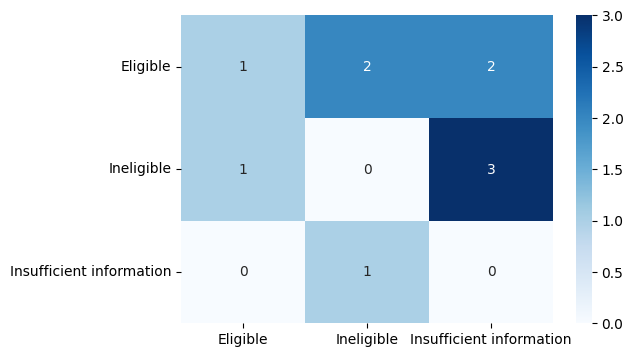

In [50]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Not', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible', 'Eligible']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

### Criteria 2

In [51]:
criteria = "Age from 45 to 70 years old"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: ' Insufficient information because age is not mentioned in the Clinical Text.',
 2: ' Eligible because the patient is a 67-year-old male which meets the age criteria of 45 to 70 years old.',
 3: ' Not Eligible because age is 23 years old which is outside the range of 45 to 70.',
 4: ' Eligible because the patient is a 69-year-old female which meets the age criteria of 45 to 70 years old.',
 5: ' Eligible because the patient is a 44-year-old male which meets the age criteria of 45 to 70 years old.',
 6: ' Eligible because the patient is a 51-year old male which meets the age criteria of 40 to 60 years old.',
 7: ' Insufficient information because age is not mentioned in the Clinical Text.',
 8: ' Insufficient information because age is not mentioned in the Clinical Text.',
 9: ' Insufficient information because age is not mentioned in the Clinical Text.',
 10: ' Eligible because the patient is a 53-year-old male which meets the age criteria of 40 to 60 years old.'}

Accuracy: 0.6


<Axes: >

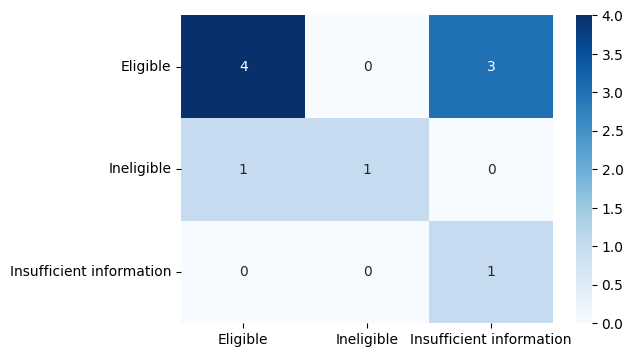

In [52]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Eligible', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Eligible', 'Eligible']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

### Criteria 3

In [53]:
criteria = "Age from 45 to 60 years old, Male"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: ' Insufficient information because age is not mentioned in the Clinical Text.',
 2: ' Eligible because the patient is a 67-year-old male which meets all criteria.',
 3: ' Not Eligible because age is 23 years old which is outside the range of 40 to 60.',
 4: ' Not Eligible because age is 69 years old which is outside the range of 45 to 60.',
 5: ' Eligible because the patient is a 44-year-old male which meets the age criteria of 40 to 60 years old.',
 6: ' Eligible because the patient is a 51-year old male which meets the age criteria of 40 to 60 years old.',
 7: ' Not Eligible because age is 48 years old which is outside the range of 45 to 60.',
 8: ' Not Eligible because age is 45 years old which is outside the range of 40 to 60.',
 9: ' Insufficient information because age is not mentioned in the Clinical Text.',
 10: ' Eligible because the patient is a 53-year-old male which meets all criteria.'}

Accuracy: 0.5


<Axes: >

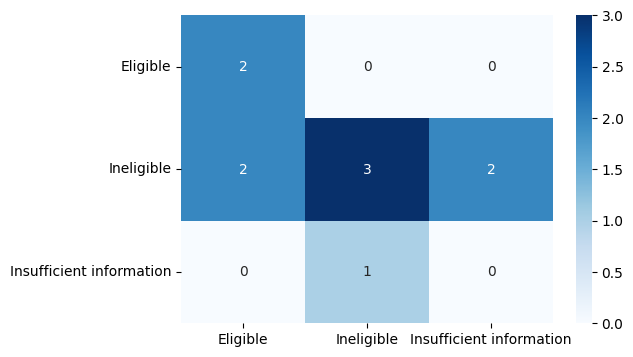

In [54]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Not', 'Not', 'Not', 'Not', 'Eligible', 'Not', 'Not', 'Insufficient', 'Not', 'Eligible']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

### Criteria 4

In [55]:
criteria = "Age from 45 to 70 years old, Male, Take insulin"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: ' Insufficient information because age is not mentioned in the Clinical Text.',
 2: ' Eligible because Patient 3 is a 67-year-old male with Type 2 Diabetes Mellitus, which meets all criteria.',
 3: ' Not Eligible because age is 23 years old which is outside the range of 40 to 60.',
 4: ' Insufficient information because age is not mentioned in the Clinical Text.',
 5: ' Insufficient information because age is not mentioned in the Clinical Text.',
 6: ' Insufficient information because age is not mentioned in the Clinical Text.',
 7: ' Insufficient information because age is not mentioned in the Clinical Text.',
 8: ' Insufficient information because age is not mentioned in the Clinical Text.',
 9: ' Insufficient information because age is not mentioned in the Clinical Text.',
 10: ' Eligible because age is 53 years old which meets the criteria of being between 40 to 60 years old and the patient is male.'}

Accuracy: 0.5


<Axes: >

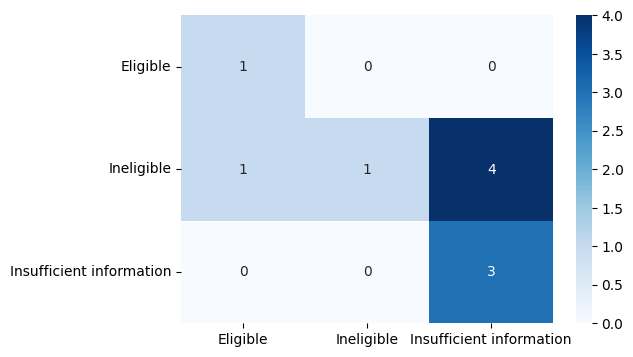

In [56]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Not', 'Eligible', 'Not', 'Not', 'Insufficient', 'Not', 'Not', 'Insufficient', 'Insufficient', 'Not']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

## Cancer

In [57]:
query = "Cancer"
prediction = search(query)

Inferencing Samples: 100%|██████████| 1/1 [00:11<00:00, 11.65s/ Batches]


### Criteria 1

In [58]:
criteria = "Age over 60 years old"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: ' Not Eligible because the patient is 80 years old which is outside the range of 40 to 60.',
 2: ' Insufficient information because age is not mentioned in the Clinical Text.',
 3: ' Not Eligible because age is 70 years old which is outside the range of 40 to 60.',
 4: ' Insufficient information because age is not mentioned in the Clinical Text.',
 5: ' Insufficient information because age is not mentioned in the Clinical Text.',
 6: ' Not Eligible because age is over 60 years old.\n',
 7: ' Not Eligible because age is 49 years old which is outside the range of 40 to 60.',
 8: ' Not Eligible because age is 84 years old which is outside the range of 40 to 60.',
 9: ' Not Eligible because age is 62 years old which is outside the range of 40 to 60.',
 10: ' Insufficient information because age is not mentioned in the Clinical Text.'}

Accuracy: 0.2


<Axes: >

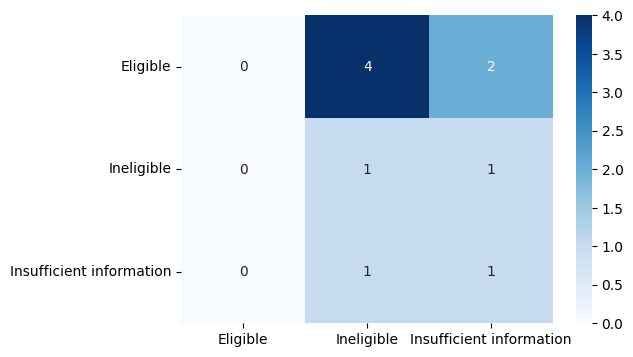

In [59]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Eligible', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Not', 'Eligible', 'Eligible', 'Insufficient']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

### Criteria 2

In [60]:
criteria = "Age from 60 to 80 years old "
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: ' Insufficient information because age is not mentioned in the Clinical Text.',
 2: ' Insufficient information because age is not mentioned in the Clinical Text.',
 3: ' Insufficient information because age is not mentioned in the Clinical Text.',
 4: ' Insufficient information because age is not mentioned in the Clinical Text.',
 5: ' Insufficient information because age is not mentioned in the Clinical Text.',
 6: ' Insufficient information because age is not mentioned in the Clinical Text.',
 7: ' Insufficient information because age is not mentioned in the Clinical Text.',
 8: ' Not Eligible because age is 84 years old which is outside the range of 60 to 80.',
 9: ' Eligible because the patient is a 62-year-old male which meets the age criteria of 60 to 80 years old.',
 10: ' Insufficient information because age is not mentioned in the Clinical Text.'}

Accuracy: 0.4


<Axes: >

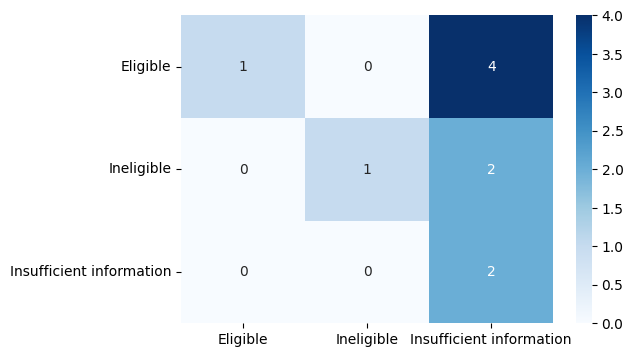

In [61]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Eligible', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Not', 'Not', 'Eligible', 'Insufficient']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

### Criteria 3

In [62]:
criteria = "Age between 50 and 85 years old, History of breast cancer"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: ' Insufficient information because age is not mentioned in the Clinical Text.',
 2: ' Insufficient information because age is not mentioned in the Clinical Text.',
 3: ' Insufficient information because age is not mentioned in the Clinical Text.',
 4: ' Insufficient information because age is not mentioned in the Clinical Text.',
 5: ' Insufficient information because age is not mentioned in the Clinical Text.',
 6: ' Not Eligible because age is 50 years old which is outside the range of 40 to 60.',
 7: ' Insufficient information because age is not mentioned in the Clinical Text.',
 8: ' Not Eligible because age is 84 years old which is outside the range of 50 to 85.',
 9: ' Insufficient information because age is not mentioned in the Clinical Text.',
 10: ' Insufficient information because age is not mentioned in the Clinical Text.'}

Accuracy: 0.2


<Axes: >

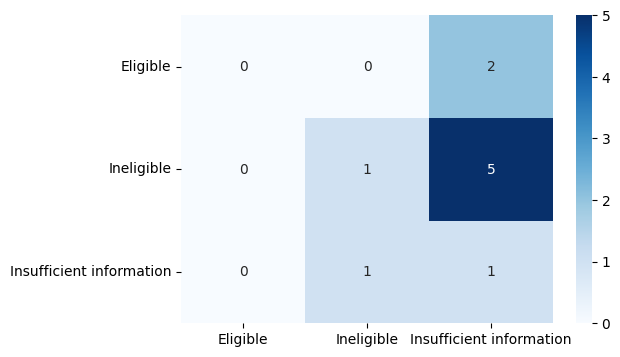

In [63]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Eligible', 'Eligible', 'Not', 'Not', 'Not', 'Insufficient', 'Not', 'Not', 'Not', 'Insufficient']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

## Arrhythmias

In [64]:
query = "Arrhythmias"
prediction = search(query)

Inferencing Samples: 100%|██████████| 1/1 [00:11<00:00, 11.03s/ Batches]


### Criteria 1

In [65]:
criteria = "Age over 21 years old"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: ' Insufficient information because age is not mentioned in the Clinical Text.',
 2: ' Eligible because the patient is a 40-year-old female which meets all criteria.',
 3: ' Insufficient information because age is not mentioned in the Clinical Text.',
 4: ' Insufficient information because age is not mentioned in the Clinical Text.',
 5: ' Insufficient information because age is not mentioned in the Clinical Text.',
 6: ' Insufficient information because age is not mentioned in the Clinical Text.',
 7: ' Eligible because the patient is 52 years old which meets the condition of age over 21 years old.',
 8: ' Eligible because age is 56 years old which meets the criteria of over 21 years old.',
 9: ' Insufficient information because patient age is not mentioned in the Clinical Text.',
 10: ' Not Eligible because the patient is 6 months old which is below the age range of 40 to 60.'}

Accuracy: 0.7


<Axes: >

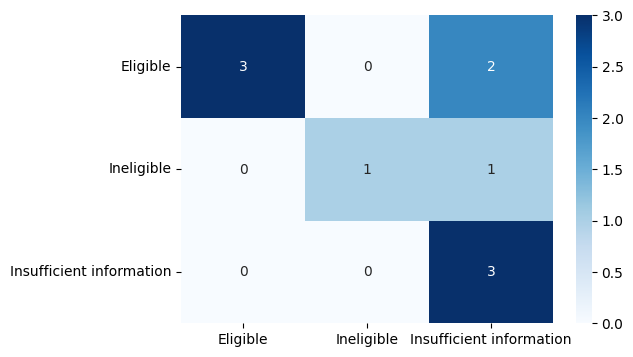

In [66]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Insufficient', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Eligible', 'Eligible', 'Eligible', 'Insufficient', 'Not']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

### Criteria 2

In [67]:
criteria = "Age from 10 to 60 years old "
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: ' Insufficient information because age is not mentioned in the Clinical Text.',
 2: ' Eligible because the patient is a 40-year-old female which meets all criteria.',
 3: ' Insufficient information because age is not mentioned in the Clinical Text.',
 4: ' Insufficient information because age is not mentioned in the Clinical Text.',
 5: ' Insufficient information because age is not mentioned in the Clinical Text.',
 6: ' Insufficient information because age is not mentioned in the Clinical Text.',
 7: ' Eligible because the patient is a 52-year-old female which meets all criteria.',
 8: ' Eligible because the patient is a 56-year-old woman which meets all criteria.',
 9: ' Insufficient information because patient age is not mentioned in the Clinical Text.',
 10: ' Insufficient information because age is not mentioned in the Clinical Text.'}

Accuracy: 0.6


<Axes: >

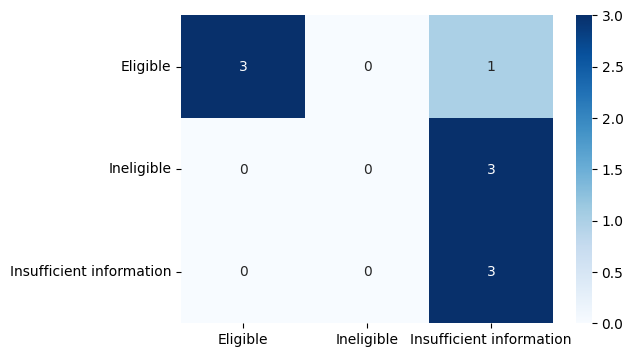

In [68]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Insufficient', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible', 'Eligible', 'Eligible', 'Insufficient', 'Not']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

### Criteria 3

In [69]:
criteria = "Age from 10 to 70 years old, Has a defibrillator"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: ' Insufficient information because age is not mentioned in the Clinical Text.',
 2: ' Eligible because the patient is a 40-year-old female with ventricular arrhythmias during neoadjuvant chemotherapy for left breast ductal cancer, which meets all criteria.',
 3: ' Insufficient information because age is not mentioned in the Clinical Text.',
 4: ' Insufficient information because age is not mentioned in the Clinical Text.',
 5: ' Insufficient information because age is not mentioned in the Clinical Text.',
 6: ' Insufficient information because age is not mentioned in the Clinical Text.',
 7: ' Eligible because the patient is 52 years old and has a defibrillator.',
 8: ' Eligible because the patient is a 56-year-old woman with dextrocardia and complex ccTGA which meets all criteria.',
 9: ' Insufficient information because age is not mentioned in the Clinical Text.',
 10: ' Insufficient information because age is not mentioned in the Clinical Text.'}

Accuracy: 0.6


<Axes: >

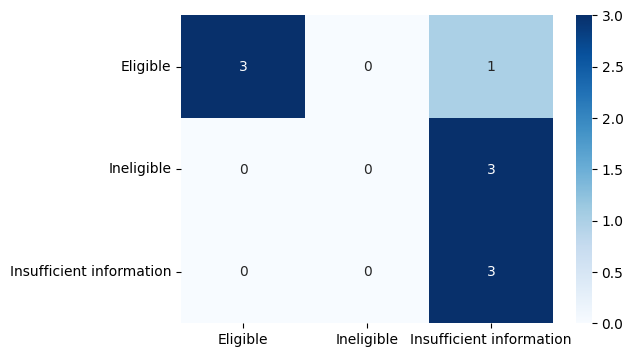

In [70]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Insufficient', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Not', 'Eligible', 'Eligible', 'Insufficient', 'Not']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

### Criteria 4

In [71]:
criteria = "Age from 20 to 50 years old, Exclude Presence of pacemaker"
criteria_results = criteria_check(criteria)
indexed_results = {i+1: result for i, result in enumerate(criteria_results)}
indexed_results

{1: ' Insufficient information because age is not mentioned in the Clinical Text.',
 2: ' Eligible because the patient is a 40-year-old female with ventricular arrhythmias during neoadjuvant chemotherapy for left breast ductal cancer, which meets all criteria.',
 3: ' Insufficient information because age is not mentioned in the Clinical Text.',
 4: ' Insufficient information because age is not mentioned in the Clinical Text.',
 5: ' Insufficient information because age is not mentioned in the Clinical Text.',
 6: ' Insufficient information because age is not mentioned in the Clinical Text.',
 7: ' Eligible because the patient is 52 years old which falls within the age range of 20 to 50 years old.',
 8: ' Insufficient information because age is not mentioned in the Clinical Text.',
 9: ' Insufficient information because patient age is not mentioned in the Clinical Text.',
 10: ' Insufficient information because age is not mentioned in the Clinical Text.'}

Accuracy: 0.4


<Axes: >

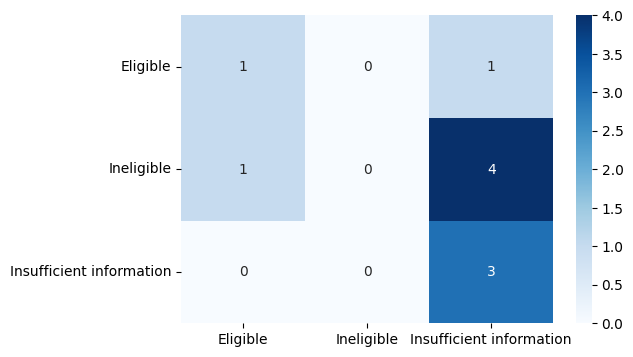

In [72]:
predicted_labels = [value.split()[0] for value in indexed_results.values()]

true_labels = ['Insufficient', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible', 'Not', 'Not', 'Insufficient', 'Not']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Eligible', 'Not', 'Insufficient'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Ineligible', 'Insufficient information'], yticklabels=['Eligible', 'Ineligible', 'Insufficient information'])

# Avg Results

In [1]:
predicted_labels_Llama_1 = ['Eligible', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Eligible', 'Eligible',
                    'Eligible', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Eligible', 'Eligible',
                    'Not', 'Not', 'Not', 'Not', 'Eligible', 'Not', 'Insufficient', 'Not', 'Not', 'Eligible',
                    'Not', 'Eligible', 'Not', 'Not', 'Eligible', 'Not', 'Insufficient', 'Not', 'Eligible', 'Not',
                    'Eligible', 'Eligible', 'Eligible', 'Insufficient', 'Not', 'Insufficient', 'Not', 'Eligible', 'Eligible', 'Insufficient',
                    'Eligible', 'Eligible', 'Eligible', 'Insufficient', 'Insufficient', 'Insufficient', 'Not', 'Not', 'Eligible', 'Insufficient',
                    'Eligible', 'Eligible', 'Not', 'Insufficient', 'Insufficient', 'Insufficient', 'Insufficient', 'Not', 'Not', 'Insufficient',
                    'Eligible', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Eligible', 'Eligible', 'Eligible', 'Eligible', 'Not',
                    'Eligible', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible', 'Eligible', 'Eligible', 'Eligible', 'Insufficient',
                    'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Insufficient', 'Eligible', 'Not', 'Eligible', 'Not',
                    'Not', 'Eligible', 'Insufficient', 'Not', 'Insufficient', 'Eligible', 'Not', 'Insufficient', 'Not', 'Insufficient'
                    ]

predicted_labels_Llama_2 = ['Eligible', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Eligible', 'Eligible',
                    'Eligible', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Eligible', 'Eligible',
                    'Not', 'Not', 'Not', 'Not', 'Eligible', 'Not', 'Not', 'Eligible', 'Not', 'Eligible',
                    'Not', 'Eligible', 'Not', 'Not', 'Eligible', 'Not', 'Not', 'Eligible', 'Not', 'Eligible',
                    'Eligible', 'Eligible', 'Eligible', 'Insufficient', 'Eligible', 'Insufficient', 'Not', 'Eligible', 'Eligible', 'Not',
                    'Eligible', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Not', 'Not', 'Eligible', 'Not',
                    'Eligible', 'Eligible', 'Eligible', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not',
                    'Eligible', 'Eligible', 'Not', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Eligible', 'Eligible', 'Not',
                    'Eligible', 'Eligible', 'Not', 'Not', 'Not', 'Eligible', 'Eligible', 'Eligible', 'Eligible', 'Not',
                    'Eligible', 'Eligible', 'Not', 'Eligible', 'Not', 'Not', 'Eligible', 'Eligible', 'Not', 'Not',
                    'Not', 'Eligible', 'Not', 'Not', 'Not', 'Eligible', 'Not', 'Not', 'Not', 'Not'
                    ]

predicted_labels_Mistral = ['Eligible', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Not', 'Not', 'Eligible', 'Eligible',
                    'Eligible', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Not', 'Not', 'Not',
                    'Not', 'Not', 'Not', 'Not', 'Eligible', 'Not', 'Not', 'Not', 'Not', 'Eligible',
                    'Not', 'Eligible', 'Not', 'Not', 'Eligible', 'Not', 'Not', 'Eligible', 'Not', 'Not',
                    'Eligible', 'Eligible', 'Eligible', 'Not', 'Not', 'Not', 'Not', 'Not', 'Eligible', 'Insufficient',
                    'Eligible', 'Not', 'Eligible', 'Not', 'Insufficient', 'Insufficient', 'Not', 'Not', 'Eligible', 'Insufficient',
                    'Eligible', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Not', 'Insufficient',
                    'Eligible', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible', 'Eligible', 'Eligible', 'Not', 'Not',
                    'Not', 'Eligible', 'Not', 'Not', 'Insufficient', 'Not', 'Not', 'Eligible', 'Not', 'Not',
                    'Eligible', 'Eligible', 'Not', 'Eligible', 'Not', 'Not', 'Eligible', 'Eligible', 'Not', 'Not',
                    'Not', 'Not', 'Not', 'Not', 'Not', 'Eligible', 'Not', 'Not', 'Not', 'Not'
                    ]

true_labels = ['Not', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible', 'Eligible',
               'Eligible', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Eligible', 'Eligible',
               'Not', 'Not', 'Not', 'Not', 'Eligible', 'Not', 'Not', 'Insufficient', 'Not', 'Eligible',
               'Not', 'Eligible', 'Not', 'Not', 'Insufficient', 'Not', 'Not', 'Insufficient', 'Insufficient', 'Not',
               'Eligible', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Not', 'Eligible', 'Eligible', 'Insufficient',
               'Eligible', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Not', 'Not', 'Eligible', 'Insufficient',
               'Eligible', 'Eligible', 'Not', 'Not', 'Not', 'Insufficient', 'Not', 'Not', 'Not', 'Insufficient',
               'Insufficient', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Eligible', 'Eligible', 'Eligible', 'Insufficient', 'Not',
               'Insufficient', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible', 'Eligible', 'Eligible', 'Insufficient', 'Not',
               'Insufficient', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Not', 'Eligible', 'Eligible', 'Insufficient', 'Not',
               'Insufficient', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible', 'Not', 'Not', 'Insufficient', 'Not'
               ]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

predicted_labels_Mistral_fewshot = ['Insufficient', 'Eligible', 'Insufficient', 'Not', 'Not', 'Eligible', 'Insufficient', 'Not', 'Insufficient', 'Insufficient',
                                    'Insufficient', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Eligible', 'Insufficient', 'Insufficient', 'Insufficient', 'Eligible',
                                    'Insufficient', 'Eligible', 'Not', 'Not', 'Eligible', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible',
                                    'Insufficient', 'Eligible', 'Not', 'Insufficient', 'Insufficient', 'Insufficient', 'Insufficient', 'Insufficient', 'Insufficient', 'Eligible',
                                    'Not', 'Insufficient', 'Not', 'Insufficient', 'Insufficient', 'Not', 'Not', 'Not', 'Not', 'Insufficient',
                                    'Insufficient', 'Insufficient', 'Insufficient', 'Insufficient', 'Insufficient', 'Insufficient', 'Insufficient', 'Not', 'Eligible', 'Insufficient',
                                    'Insufficient', 'Insufficient', 'Insufficient', 'Insufficient', 'Insufficient', 'Not', 'Insufficient', 'Not', 'Insufficient', 'Insufficient',
                                    'Insufficient', 'Eligible', 'Insufficient', 'Insufficient', 'Insufficient', 'Insufficient', 'Eligible', 'Eligible', 'Insufficient', 'Not',
                                    'Insufficient', 'Eligible', 'Insufficient', 'Insufficient', 'Insufficient', 'Insufficient', 'Eligible', 'Eligible', 'Insufficient', 'Insufficient',
                                    'Insufficient', 'Eligible', 'Insufficient', 'Insufficient', 'Insufficient', 'Insufficient', 'Eligible', 'Eligible', 'Insufficient', 'Insufficient',
                                    'Insufficient', 'Eligible', 'Insufficient', 'Insufficient', 'Insufficient', 'Insufficient', 'Eligible', 'Insufficient', 'Insufficient', 'Insufficient'
                                    ]

predicted_labels_Llama_fewshot = ['Eligible', 'Eligible', 'Not', 'Eligible', 'Not', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Eligible',
                                'Eligible', 'Eligible', 'Not', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Insufficient', 'Eligible', 'Eligible',
                                'Not', 'Not', 'Not', 'Not', 'Not', 'Eligible', 'Not', 'Insufficient', 'Not', 'Eligible',
                                'Not', 'Eligible', 'Not', 'Not', 'Eligible', 'Eligible', 'Not', 'Insufficient', 'Not', 'Not',
                                'Eligible', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Insufficient',
                                'Eligible', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Not', 'Eligible', 'Eligible',
                                'Not', 'Eligible', 'Not', 'Not', 'Not', 'Insufficient', 'Not', 'Not', 'Not', 'Insufficient',
                                'Insufficient', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Insufficient', 'Not',
                                'Insufficient', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Eligible', 'Eligible', 'Eligible', 'Not', 'Not',
                                'Insufficient', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Not', 'Eligible', 'Eligible', 'Eligible', 'Not',
                                'Insufficient', 'Insufficient', 'Not', 'Not', 'Insufficient', 'Eligible', 'Eligible', 'Eligible', 'Insufficient', 'Not'
                                ]

true_labels = ['Not', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible', 'Eligible',
               'Eligible', 'Eligible', 'Not', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Eligible', 'Eligible',
               'Not', 'Not', 'Not', 'Not', 'Eligible', 'Not', 'Not', 'Insufficient', 'Not', 'Eligible',
               'Not', 'Eligible', 'Not', 'Not', 'Insufficient', 'Not', 'Not', 'Insufficient', 'Insufficient', 'Not',
               'Eligible', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Not', 'Eligible', 'Eligible', 'Insufficient',
               'Eligible', 'Eligible', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Not', 'Not', 'Eligible', 'Insufficient',
               'Eligible', 'Eligible', 'Not', 'Not', 'Not', 'Insufficient', 'Not', 'Not', 'Not', 'Insufficient',
               'Insufficient', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Eligible', 'Eligible', 'Eligible', 'Insufficient', 'Not',
               'Insufficient', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible', 'Eligible', 'Eligible', 'Insufficient', 'Not',
               'Insufficient', 'Eligible', 'Not', 'Eligible', 'Insufficient', 'Not', 'Eligible', 'Eligible', 'Insufficient', 'Not',
               'Insufficient', 'Eligible', 'Not', 'Not', 'Insufficient', 'Eligible', 'Not', 'Not', 'Insufficient', 'Not'
               ]

# Calculate accuracy, precision, recall, and F1 score for Llama predictions version fewshot
accuracy_llama_f = accuracy_score(true_labels, predicted_labels_Llama_fewshot)
precision_llama_f = precision_score(true_labels, predicted_labels_Llama_fewshot, average='macro', labels=['Eligible', 'Not', 'Insufficient'])
recall_llama_f = recall_score(true_labels, predicted_labels_Llama_fewshot, average='macro', labels=['Eligible', 'Not', 'Insufficient'])
f1_llama_f = f1_score(true_labels, predicted_labels_Llama_fewshot, average='macro', labels=['Eligible', 'Not', 'Insufficient'])

print("Llama3_fewshot - Accuracy:", round(accuracy_llama_f, 3))
print("Llama3_fewshot - Precision:", round(precision_llama_f, 3))
print("Llama3_fewshot - Recall:", round(recall_llama_f, 3))
print("Llama3_fewshot - F1 Score:", round(f1_llama_f, 3))

Llama3_fewshot - Accuracy: 0.782
Llama3_fewshot - Precision: 0.822
Llama3_fewshot - Recall: 0.753
Llama3_fewshot - F1 Score: 0.771


In [75]:
accuracy_llama_f = accuracy_score(true_labels, predicted_labels_Mistral_fewshot)
precision_llama_f = precision_score(true_labels, predicted_labels_Mistral_fewshot, average='macro', labels=['Eligible', 'Not', 'Insufficient'])
recall_llama_f = recall_score(true_labels, predicted_labels_Mistral_fewshot, average='macro', labels=['Eligible', 'Not', 'Insufficient'])
f1_llama_f = f1_score(true_labels, predicted_labels_Mistral_fewshot, average='macro', labels=['Eligible', 'Not', 'Insufficient'])

print("Llama3_fewshot - Accuracy:", round(accuracy_llama_f, 3))
print("Llama3_fewshot - Precision:", round(precision_llama_f, 3))
print("Llama3_fewshot - Recall:", round(recall_llama_f, 3))
print("Llama3_fewshot - F1 Score:", round(f1_llama_f, 3))

Llama3_fewshot - Accuracy: 0.436
Llama3_fewshot - Precision: 0.512
Llama3_fewshot - Recall: 0.495
Llama3_fewshot - F1 Score: 0.431


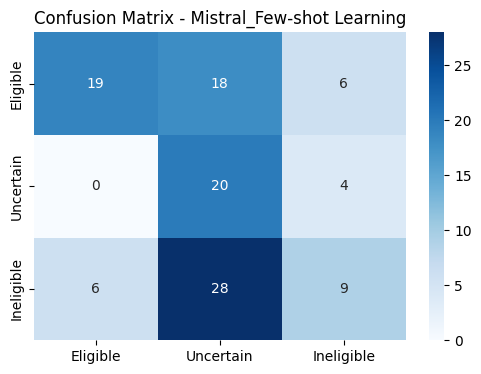

In [76]:
# Generate confusion matrix for Llama predictions version 1
conf_matrix_llama_f = confusion_matrix(true_labels, predicted_labels_Mistral_fewshot, labels=['Eligible', 'Insufficient', 'Not'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_llama_f, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Uncertain', 'Ineligible'], yticklabels=['Eligible', 'Uncertain', 'Ineligible'])
plt.title('Confusion Matrix - Mistral_Few-shot Learning')
plt.show()

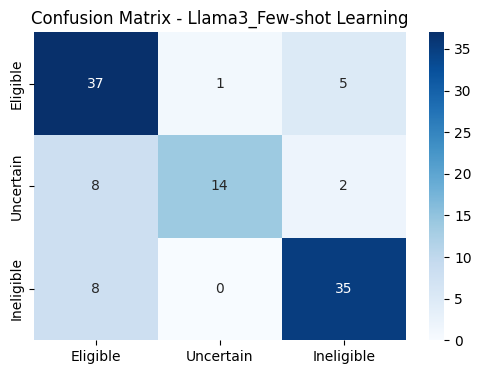

In [13]:
# Generate confusion matrix for Llama predictions version 1
conf_matrix_llama_f = confusion_matrix(true_labels, predicted_labels_Llama_fewshot, labels=['Eligible', 'Insufficient', 'Not'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_llama_f, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Uncertain', 'Ineligible'], yticklabels=['Eligible', 'Uncertain', 'Ineligible'])
plt.title('Confusion Matrix - Llama3_Few-shot Learning')
plt.show()

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate accuracy, precision, recall, and F1 score for Llama predictions version 1
accuracy_llama_1 = accuracy_score(true_labels, predicted_labels_Llama_1)
precision_llama_1 = precision_score(true_labels, predicted_labels_Llama_1, average='macro', labels=['Eligible', 'Not', 'Insufficient'])
recall_llama_1 = recall_score(true_labels, predicted_labels_Llama_1, average='macro', labels=['Eligible', 'Not', 'Insufficient'])
f1_llama_1 = f1_score(true_labels, predicted_labels_Llama_1, average='macro', labels=['Eligible', 'Not', 'Insufficient'])

print("Llama3_1 - Accuracy:", round(accuracy_llama_1, 3))
print("Llama3_1 - Precision:", round(precision_llama_1, 3))
print("Llama3_1 - Recall:", round(recall_llama_1, 3))
print("Llama3_1 - F1 Score:", round(f1_llama_1, 3))

# Calculate accuracy, precision, recall, and F1 score for Llama predictions version 2
accuracy_llama_2 = accuracy_score(true_labels, predicted_labels_Llama_2)
precision_llama_2 = precision_score(true_labels, predicted_labels_Llama_2, average='macro', labels=['Eligible', 'Not', 'Insufficient'])
recall_llama_2 = recall_score(true_labels, predicted_labels_Llama_2, average='macro', labels=['Eligible', 'Not', 'Insufficient'])
f1_llama_2 = f1_score(true_labels, predicted_labels_Llama_2, average='macro', labels=['Eligible', 'Not', 'Insufficient'])

print("Llama3_2 - Accuracy:", round(accuracy_llama_2, 3))
print("Llama3_2 - Precision:", round(precision_llama_2, 3))
print("Llama3_2 - Recall:", round(recall_llama_2, 3))
print("Llama3_2 - F1 Score:", round(f1_llama_2, 3))

# Calculate accuracy, precision, recall, and F1 score for Mistral predictions
accuracy_mistral = accuracy_score(true_labels, predicted_labels_Mistral)
precision_mistral = precision_score(true_labels, predicted_labels_Mistral, average='macro', labels=['Eligible', 'Not', 'Insufficient'])
recall_mistral = recall_score(true_labels, predicted_labels_Mistral, average='macro', labels=['Eligible', 'Not', 'Insufficient'])
f1_mistral = f1_score(true_labels, predicted_labels_Mistral, average='macro', labels=['Eligible', 'Not', 'Insufficient'])

print("Mistral - Accuracy:", round(accuracy_mistral, 3))
print("Mistral - Precision:", round(precision_mistral, 3))
print("Mistral - Recall:", round(recall_mistral, 3))
print("Mistral - F1 Score:", round(f1_mistral, 3))

Llama3_1 - Accuracy: 0.727
Llama3_1 - Precision: 0.69
Llama3_1 - Recall: 0.688
Llama3_1 - F1 Score: 0.684
Llama3_2 - Accuracy: 0.764
Llama3_2 - Precision: 0.759
Llama3_2 - Recall: 0.67
Llama3_2 - F1 Score: 0.633
Mistral - Accuracy: 0.727
Mistral - Precision: 0.786
Mistral - Recall: 0.657
Mistral - F1 Score: 0.653


In [7]:
print("Accuracy: Llama3", round(accuracy_llama_1, 3), ", Mistral", round(accuracy_mistral, 3))
print("Precision: Llama3", round(precision_llama_1, 3), ", Mistral", round(precision_mistral, 3))
print("Recall: Llama3", round(recall_llama_1, 3), ", Mistral", round(recall_mistral, 3))
print("F1 Score: Llama3", round(f1_llama_1, 3), ", Mistral", round(f1_mistral, 3))

Accuracy: Llama3 0.727 , Mistral 0.727
Precision: Llama3 0.69 , Mistral 0.786
Recall: Llama3 0.688 , Mistral 0.657
F1 Score: Llama3 0.684 , Mistral 0.653


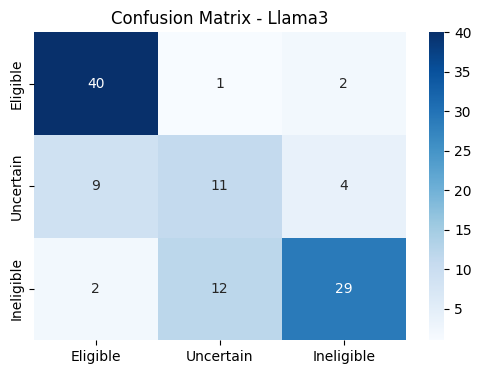

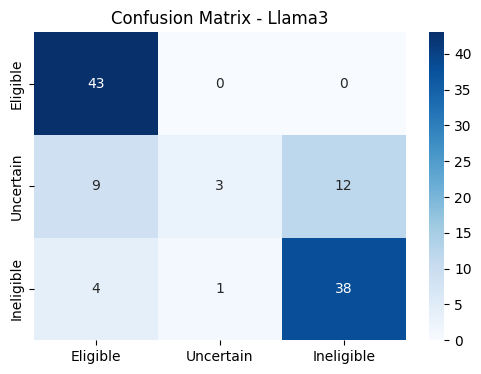

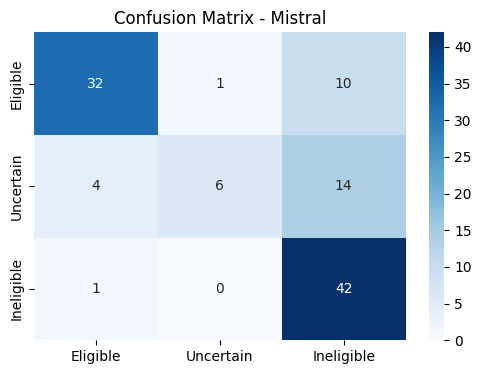

In [9]:
# Generate confusion matrix for Llama predictions version 1
conf_matrix_llama_1 = confusion_matrix(true_labels, predicted_labels_Llama_1, labels=['Eligible', 'Insufficient', 'Not'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_llama_1, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Uncertain', 'Ineligible'], yticklabels=['Eligible', 'Uncertain', 'Ineligible'])
plt.title('Confusion Matrix - Llama3')
plt.show()

# Generate confusion matrix for Llama predictions version 2
conf_matrix_llama_2 = confusion_matrix(true_labels, predicted_labels_Llama_2, labels=['Eligible', 'Insufficient', 'Not'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_llama_2, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Uncertain', 'Ineligible'], yticklabels=['Eligible', 'Uncertain', 'Ineligible'])
plt.title('Confusion Matrix - Llama3')
plt.show()

# Generate confusion matrix for Mistral predictions
conf_matrix_mistral = confusion_matrix(true_labels, predicted_labels_Mistral, labels=['Eligible', 'Insufficient', 'Not'])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_mistral, annot=True, fmt="d", cmap="Blues", xticklabels=['Eligible', 'Uncertain', 'Ineligible'], yticklabels=['Eligible', 'Uncertain', 'Ineligible'])
plt.title('Confusion Matrix - Mistral')
plt.show()